In [2]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
import nmrglue as ng
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 300

In [3]:
## Name model, and load and preprocess dataset

In [4]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = "TCN_21Met" + str(num_epochs) +"ep"

# Set the random seed
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics/') 
seed = 1 
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [ ]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra400 = np.load('Dataset21_400MHz_Spec.npy')
spectra100 = np.load('Dataset21_100MHz_Spec.npy')
conc1 = np.load('Dataset21_Conc.npy')

# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')
spectraValConc = np.load('Dataset21_Val_Conc.npy')

# Load representative validation spectra
RepSpectra400 = np.load("Dataset21_400MHz_RepresentativeExamples_Spectra.npy")
RepSpectra100 = np.load("Dataset21_100MHz_RepresentativeExamples_Spectra.npy")
RepConc = np.load("Dataset21_RepresentativeExamples_Concentrations.npy")
RepSpecNames = np.load("Dataset21_RepresentativeExamples_VariableNames.npy")

In [5]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [6]:
## Set up data for testing and training

# Split into testing and training data
X_train, X_test, y_train, y_test = train_test_split(spectra100, spectra400, test_size = 0.2, random_state = 1)

# Tensorize and prepare datasets
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()


# Move the input data to the GPU device
X_train = X_train.to(device)
X_test = X_test.to(device)
#spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
#RepSpectra100 = torch.tensor(RepSpectra100).float().to(device)   # These spectra are the representative example spectra

# Move the target data to the GPU device
y_train = y_train.to(device)
y_test = y_test.to(device)
#spectraVal400 = torch.tensor(spectraVal400).float().to(device)
#RepSpectra400 = torch.tensor(RepSpectra400).float().to(device)

# More data prep?
datasets = torch.utils.data.TensorDataset(X_train, y_train)
Test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
train_iter = torch.utils.data.DataLoader(datasets, batch_size = 32, shuffle=True)
test_iter = torch.utils.data.DataLoader(Test_datasets, batch_size = 32, shuffle=True)

In [7]:
del X_train
del X_test
del y_train
del y_test

In [6]:
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TCN(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TCN, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        self.network = nn.Sequential(*layers)
        self.final_conv = nn.Conv1d(num_channels[-1], num_inputs, kernel_size=1)

    def forward(self, x):
        x = self.network(x)
        return self.final_conv(x)

In [9]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 25  # Set how many epochs without improvement in validation loss constitutes early stopping

    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        
         # Instantiate the GradScaler
        scaler = GradScaler()
        for inputs, labels in train_loader:
            # Move data to GPU
             inputs, labels = inputs.to(device), labels.to(device)
             inputs = inputs.unsqueeze(1)
             labels = labels.unsqueeze(1)
            # Zero the parameter gradients
             optimizer.zero_grad()
            # Enable autocasting for forward and backward passes
             with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
             train_loss += loss.item() * inputs.size(0)
             # Scale the loss and perform backpropagation
             scaler.scale(loss).backward()
             # Step the optimizer
             scaler.step(optimizer)
              # Update the scaler
             scaler.update()
        train_losses.append(train_loss)

        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.unsqueeze(1)
                labels = labels.unsqueeze(1)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
            
            
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [12]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Create model
model = TCN(1, [25, 50, 100])

# Move the model to the GPU device
model.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params3.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/300], Train Loss: 3.8413, Test Loss: 0.5984
Epoch time:  72.86467242240906
Epoch [2/300], Train Loss: 2.2424, Test Loss: 0.5448
Epoch time:  71.26097416877747
Epoch [3/300], Train Loss: 2.1597, Test Loss: 0.5248
Epoch time:  71.24215483665466
Epoch [4/300], Train Loss: 2.0943, Test Loss: 0.5114
Epoch time:  71.24152636528015
Epoch [5/300], Train Loss: 2.0516, Test Loss: 0.5026
Epoch time:  71.49142050743103
Epoch [6/300], Train Loss: 2.0204, Test Loss: 0.4985
Epoch time:  71.28428173065186
Epoch [7/300], Train Loss: 1.9994, Test Loss: 0.4940
Epoch time:  71.23704195022583
Epoch [8/300], Train Loss: 1.9944, Test Loss: 0.4950
Epoch time:  71.21267890930176
Epoch [9/300], Train Loss: 1.9839, Test Loss: 0.4916
Epoch time:  71.23272562026978
Epoch [10/300], Train Loss: 1.9749, Test Loss: 0.4903
Epoch time:  71.23111605644226
Epoch [11/300], Train Loss: 1.9686, Test Loss: 0.4906
Epoch time:  71.20776796340942
Epoch [12/300], Train Lo

Epoch [98/300], Train Loss: 1.8579, Test Loss: 0.4756
Epoch time:  71.19371962547302
Epoch [99/300], Train Loss: 1.8570, Test Loss: 0.4762
Epoch time:  71.18109703063965
Epoch [100/300], Train Loss: 1.8569, Test Loss: 0.4782
Epoch time:  71.18347144126892
Epoch [101/300], Train Loss: 1.8576, Test Loss: 0.4799
Epoch time:  71.18768811225891
Epoch [102/300], Train Loss: 1.8558, Test Loss: 0.4727
Epoch time:  71.18796396255493
Epoch [103/300], Train Loss: 1.8571, Test Loss: 0.4737
Epoch time:  71.18649315834045
Epoch [104/300], Train Loss: 1.8567, Test Loss: 0.4751
Epoch time:  71.18220734596252
Epoch [105/300], Train Loss: 1.8563, Test Loss: 0.4742
Epoch time:  71.19030857086182
Epoch [106/300], Train Loss: 1.8560, Test Loss: 0.4730
Epoch time:  71.19524025917053
Epoch [107/300], Train Loss: 1.8559, Test Loss: 0.4778
Epoch time:  71.18481278419495
Epoch [108/300], Train Loss: 1.8554, Test Loss: 0.4771
Epoch time:  71.18239307403564
Epoch [109/300], Train Loss: 1.8543, Test Loss: 0.4729
E

In [7]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir('/home/htjhnson/Desktop/LF_to_HF/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params3.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model = TCN(1, [25, 50, 100])

# Load the model's state dictionary from the loaded dictionary
model.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model.to(device)

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


TCN(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): Conv1d(1, 25, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.2, inplace=False)
      (conv2): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(1,))
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.2, inplace=False)
      (net): Sequential(
        (0): Conv1d(1, 25, kernel_size=(2,), stride=(1,), padding=(1,))
        (1): Chomp1d()
        (2): ReLU()
        (3): Dropout(p=0.2, inplace=False)
        (4): Conv1d(25, 25, kernel_size=(2,), stride=(1,), padding=(1,))
        (5): Chomp1d()
        (6): ReLU()
        (7): Dropout(p=0.2, inplace=False)
      )
      (downsample): Conv1d(1, 25, kernel_size=(1,), stride=(1,))
      (relu): ReLU()
    )
    (1): TemporalBlock(
      (conv1): Conv1d(25, 50, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
      (chomp1): Chomp1d()
      (relu1): ReLU()
 

In [8]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir('/home/htjhnson/Desktop/LF_to_HF/GeneratedDataAndVariables')


# Load validation dataset
spectraVal400 = np.load('Dataset21_400MHz_Val_Spec.npy')
spectraVal100 = np.load('Dataset21_100MHz_Val_Spec.npy')


spectraVal100 = torch.tensor(spectraVal100).float().to(device)   # These spectra are the 5000 spectra generated like the training dataset
spectraVal400 = torch.tensor(spectraVal400).float().to(device)

In [9]:
## Switch to directory for saving model metrics
os.chdir('/home/htjhnson/Desktop/LF_to_HF/ModelPerformanceMetrics')

criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(spectraVal100[:100].unsqueeze(1))  # Evaluate input spectra 

mse = criterion(outputs, spectraVal400[:100])


# Print RMSE
print('model err: ', mse)  # Print RMSE

# Save RMSE to a file
np.save(ModelName + "ValMSE.npy", mse.cpu().detach().numpy())

model err:  tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([100, 46000])) that is different to the input size (torch.Size([100, 1, 46000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [9]:
## Create ppm scale for plotting ppm rather than just data point numbers for x-axis
ppm_all = (np.linspace(12.5, -2.5, 65536))
ppm = ppm_all[10000:56000]

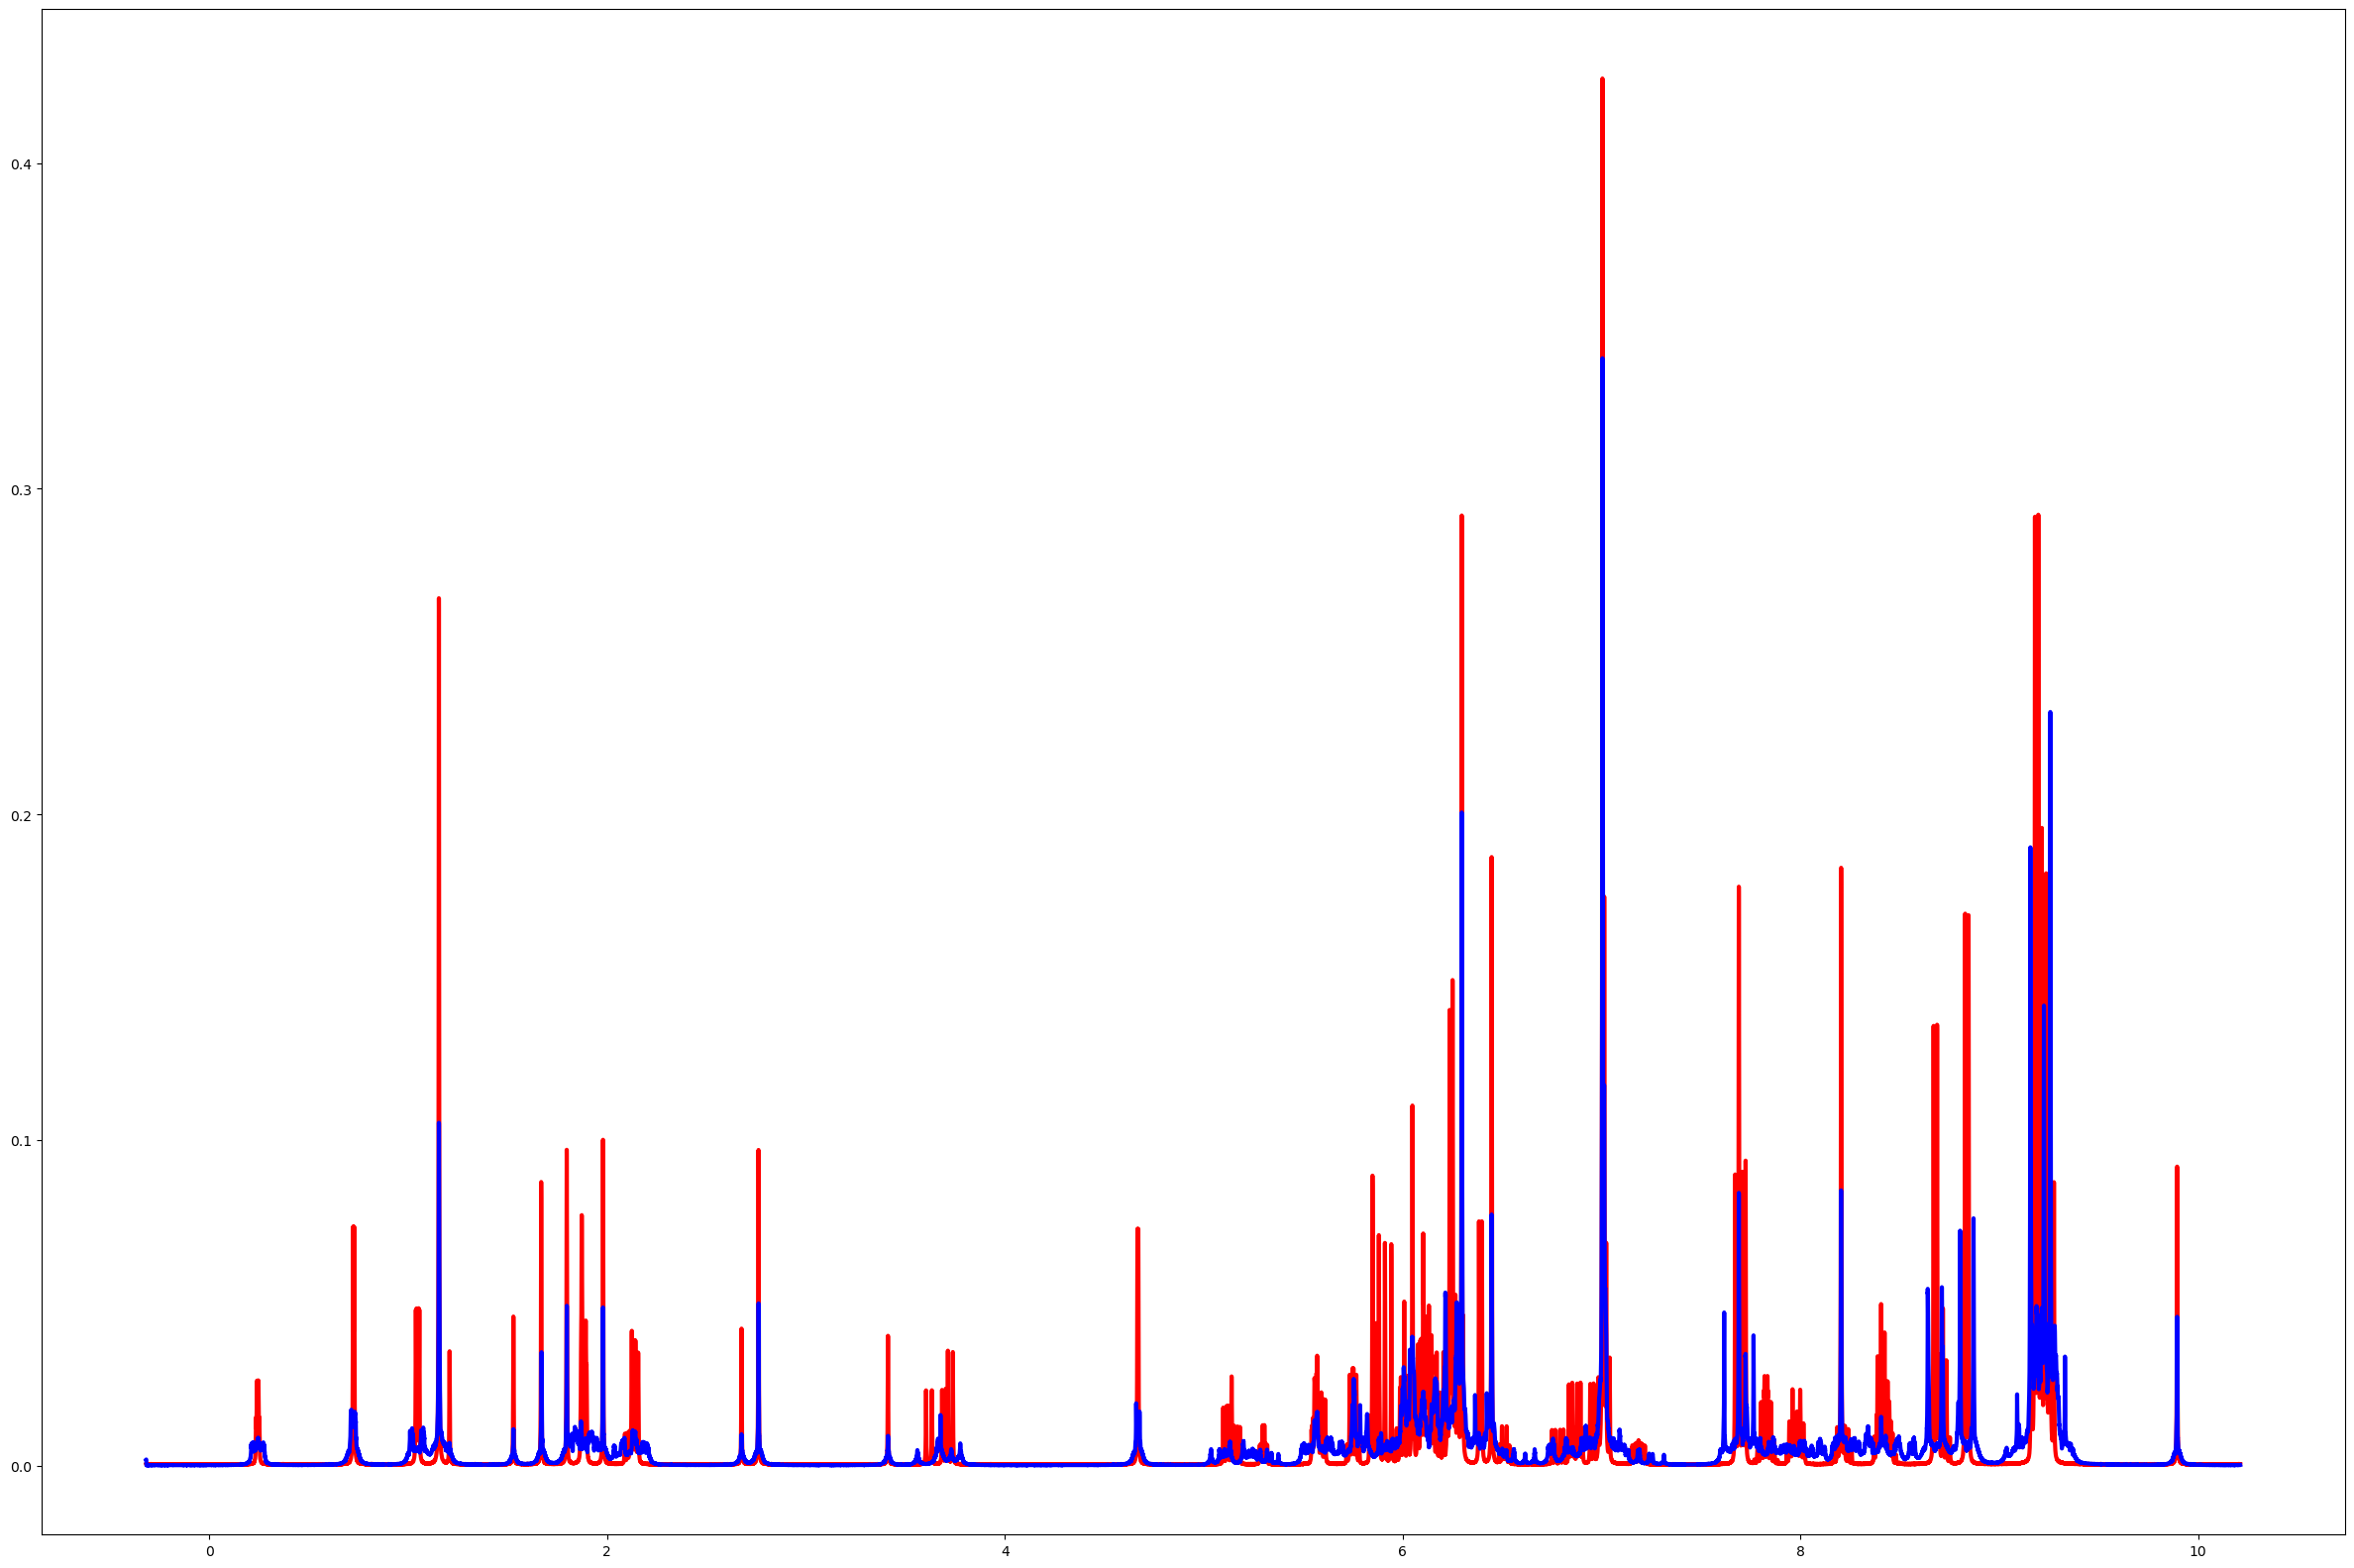

/home/htjhnson/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([46000])) that is different to the input size (torch.Size([1, 46000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


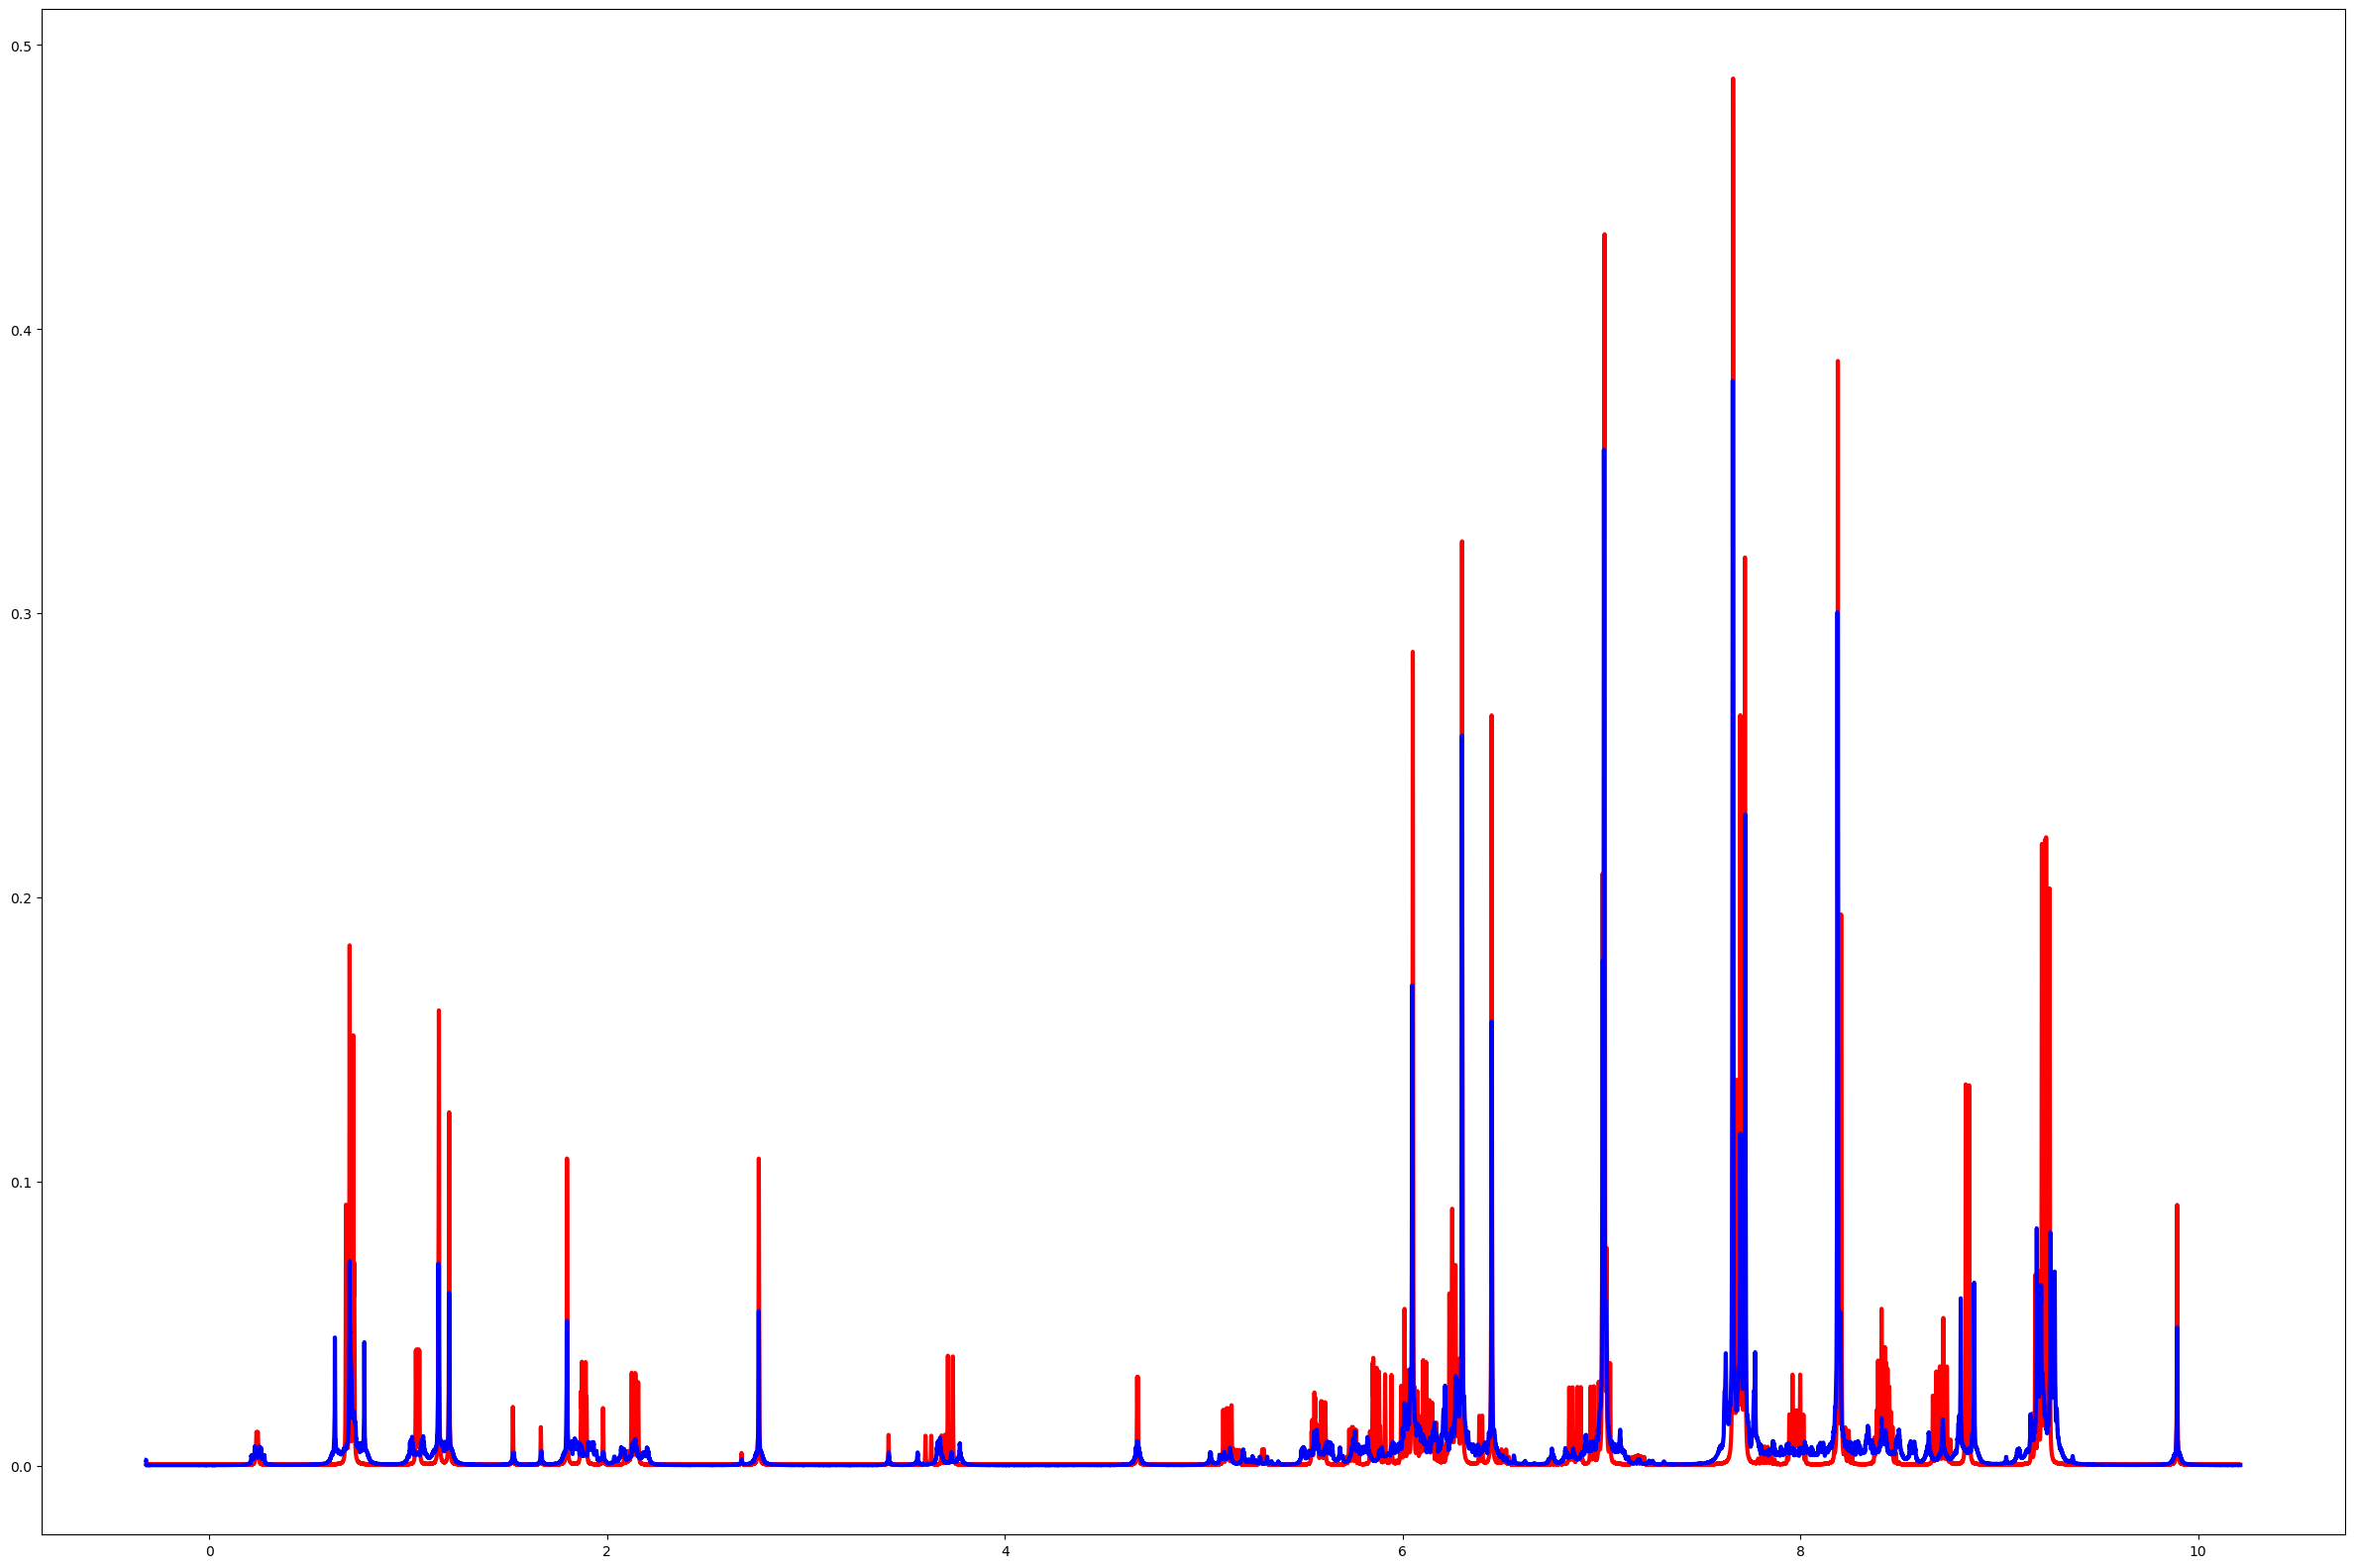

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


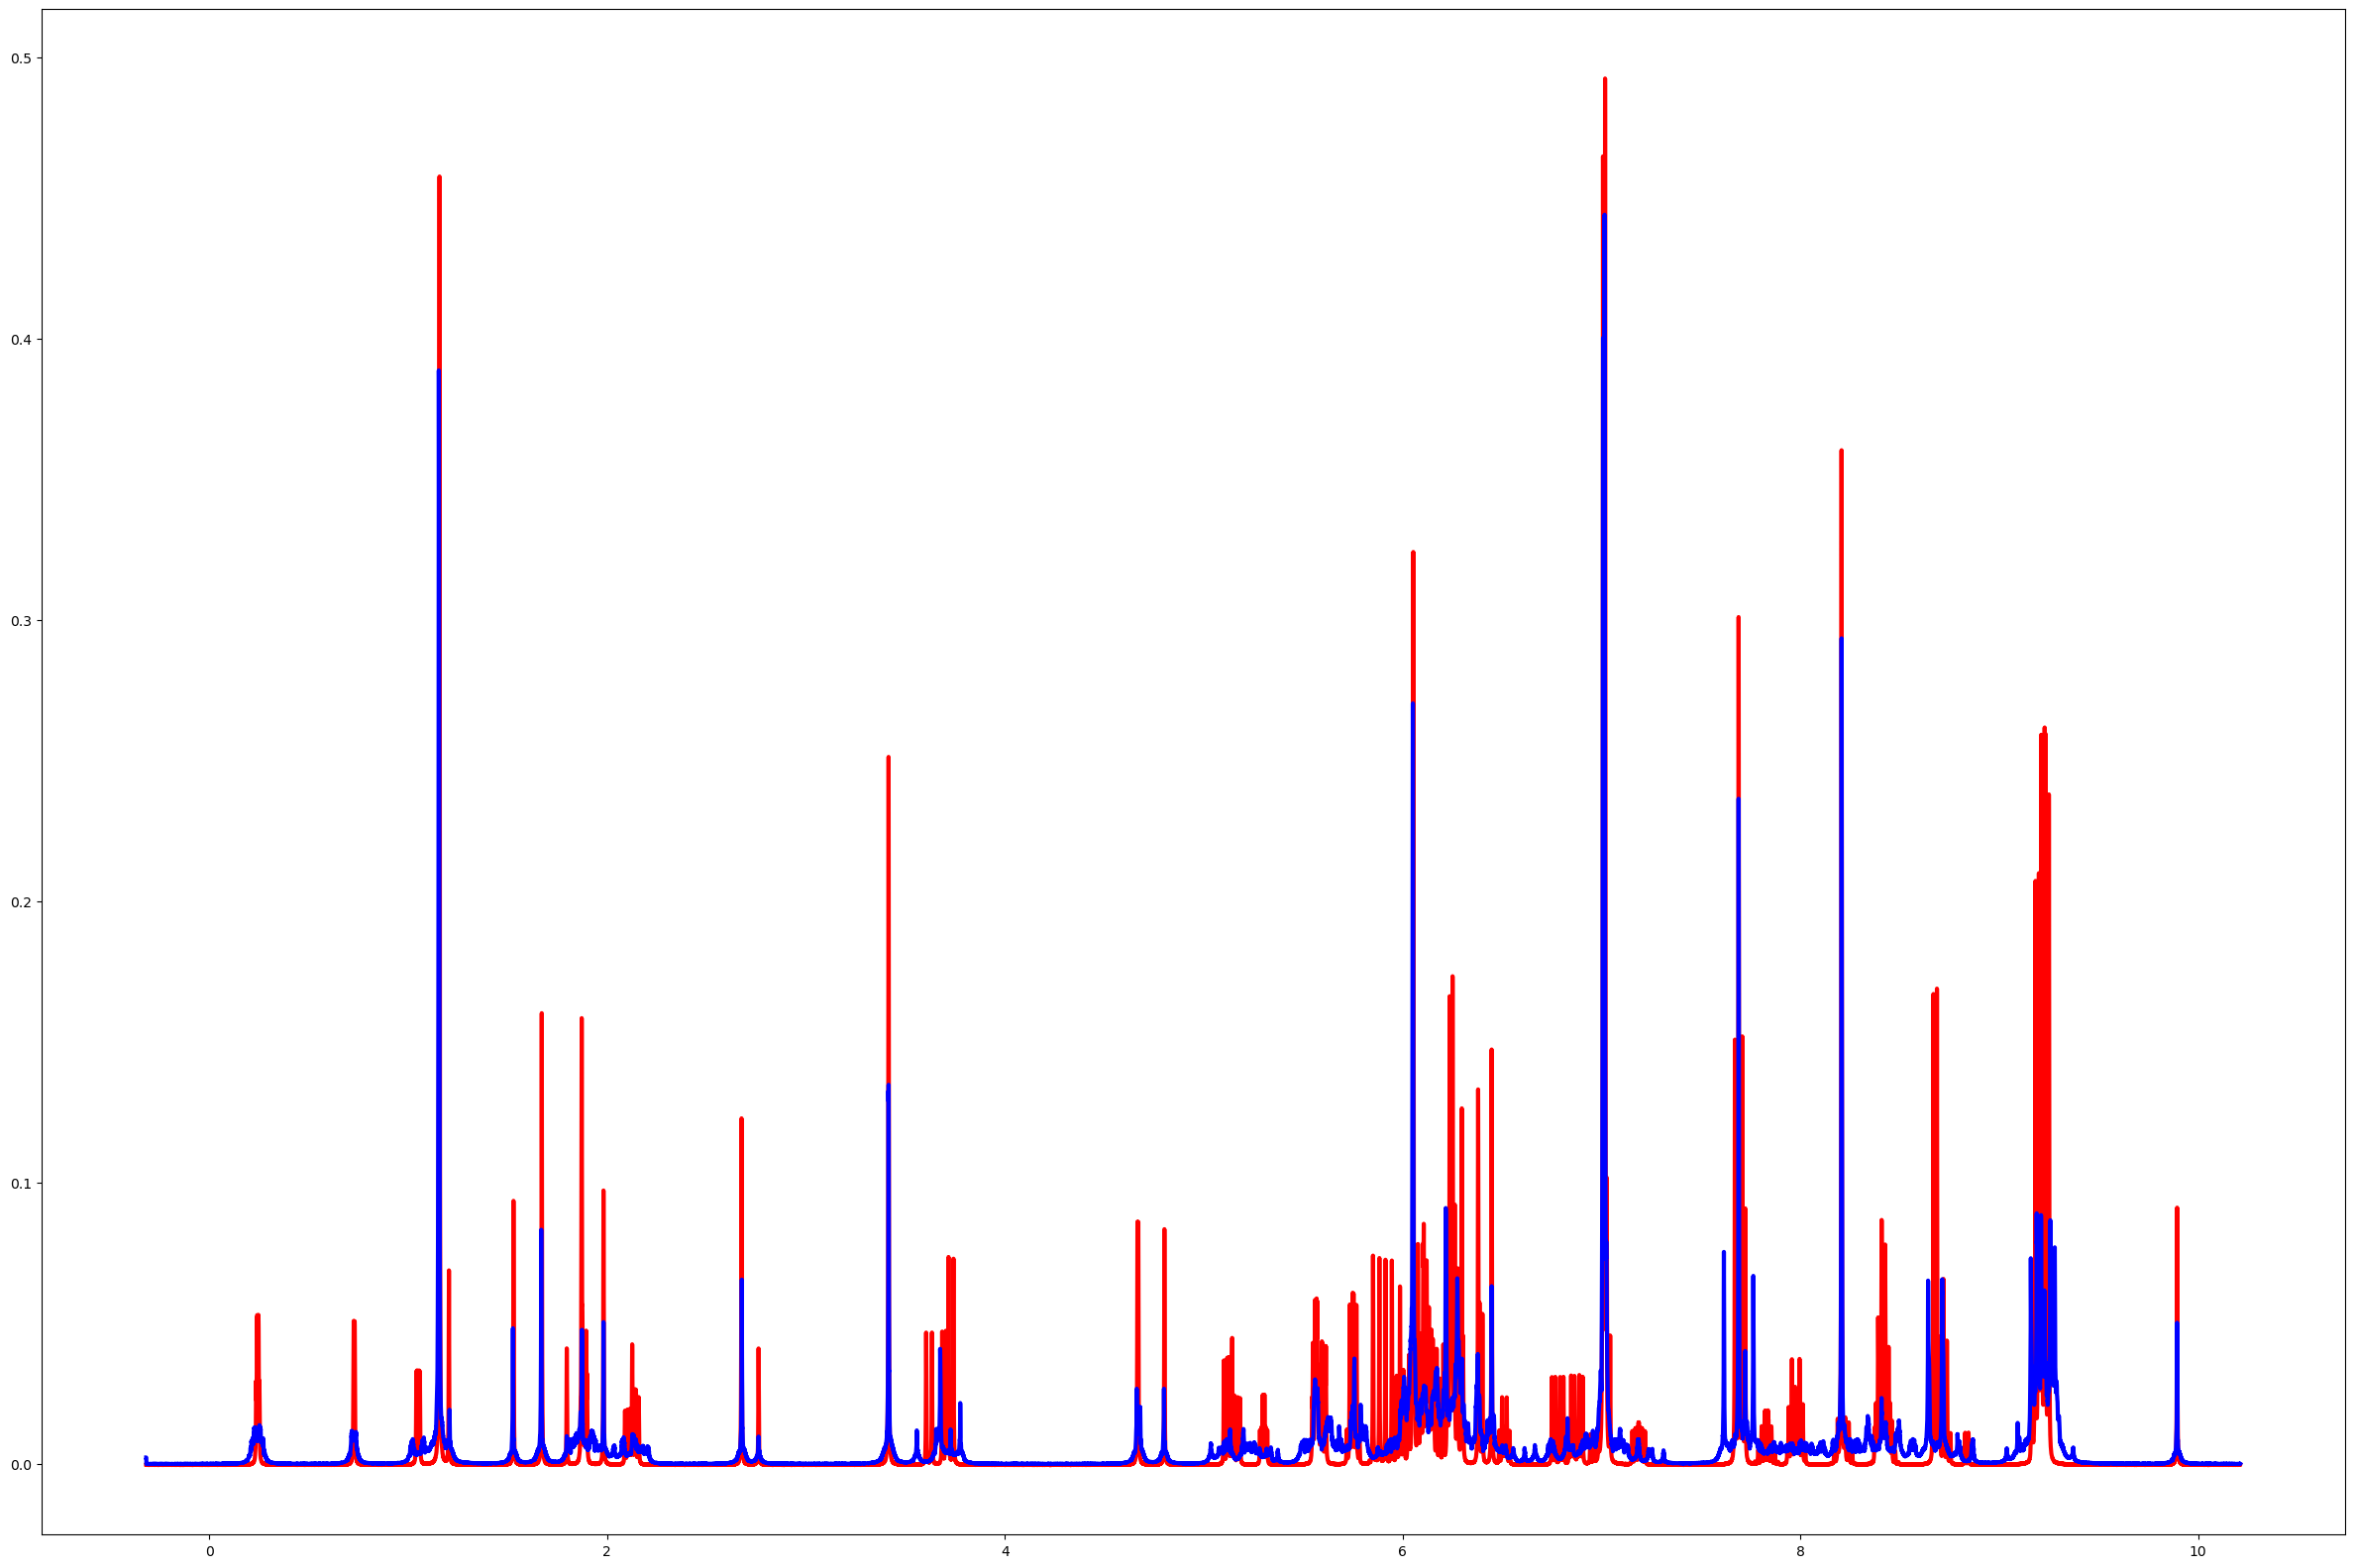

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


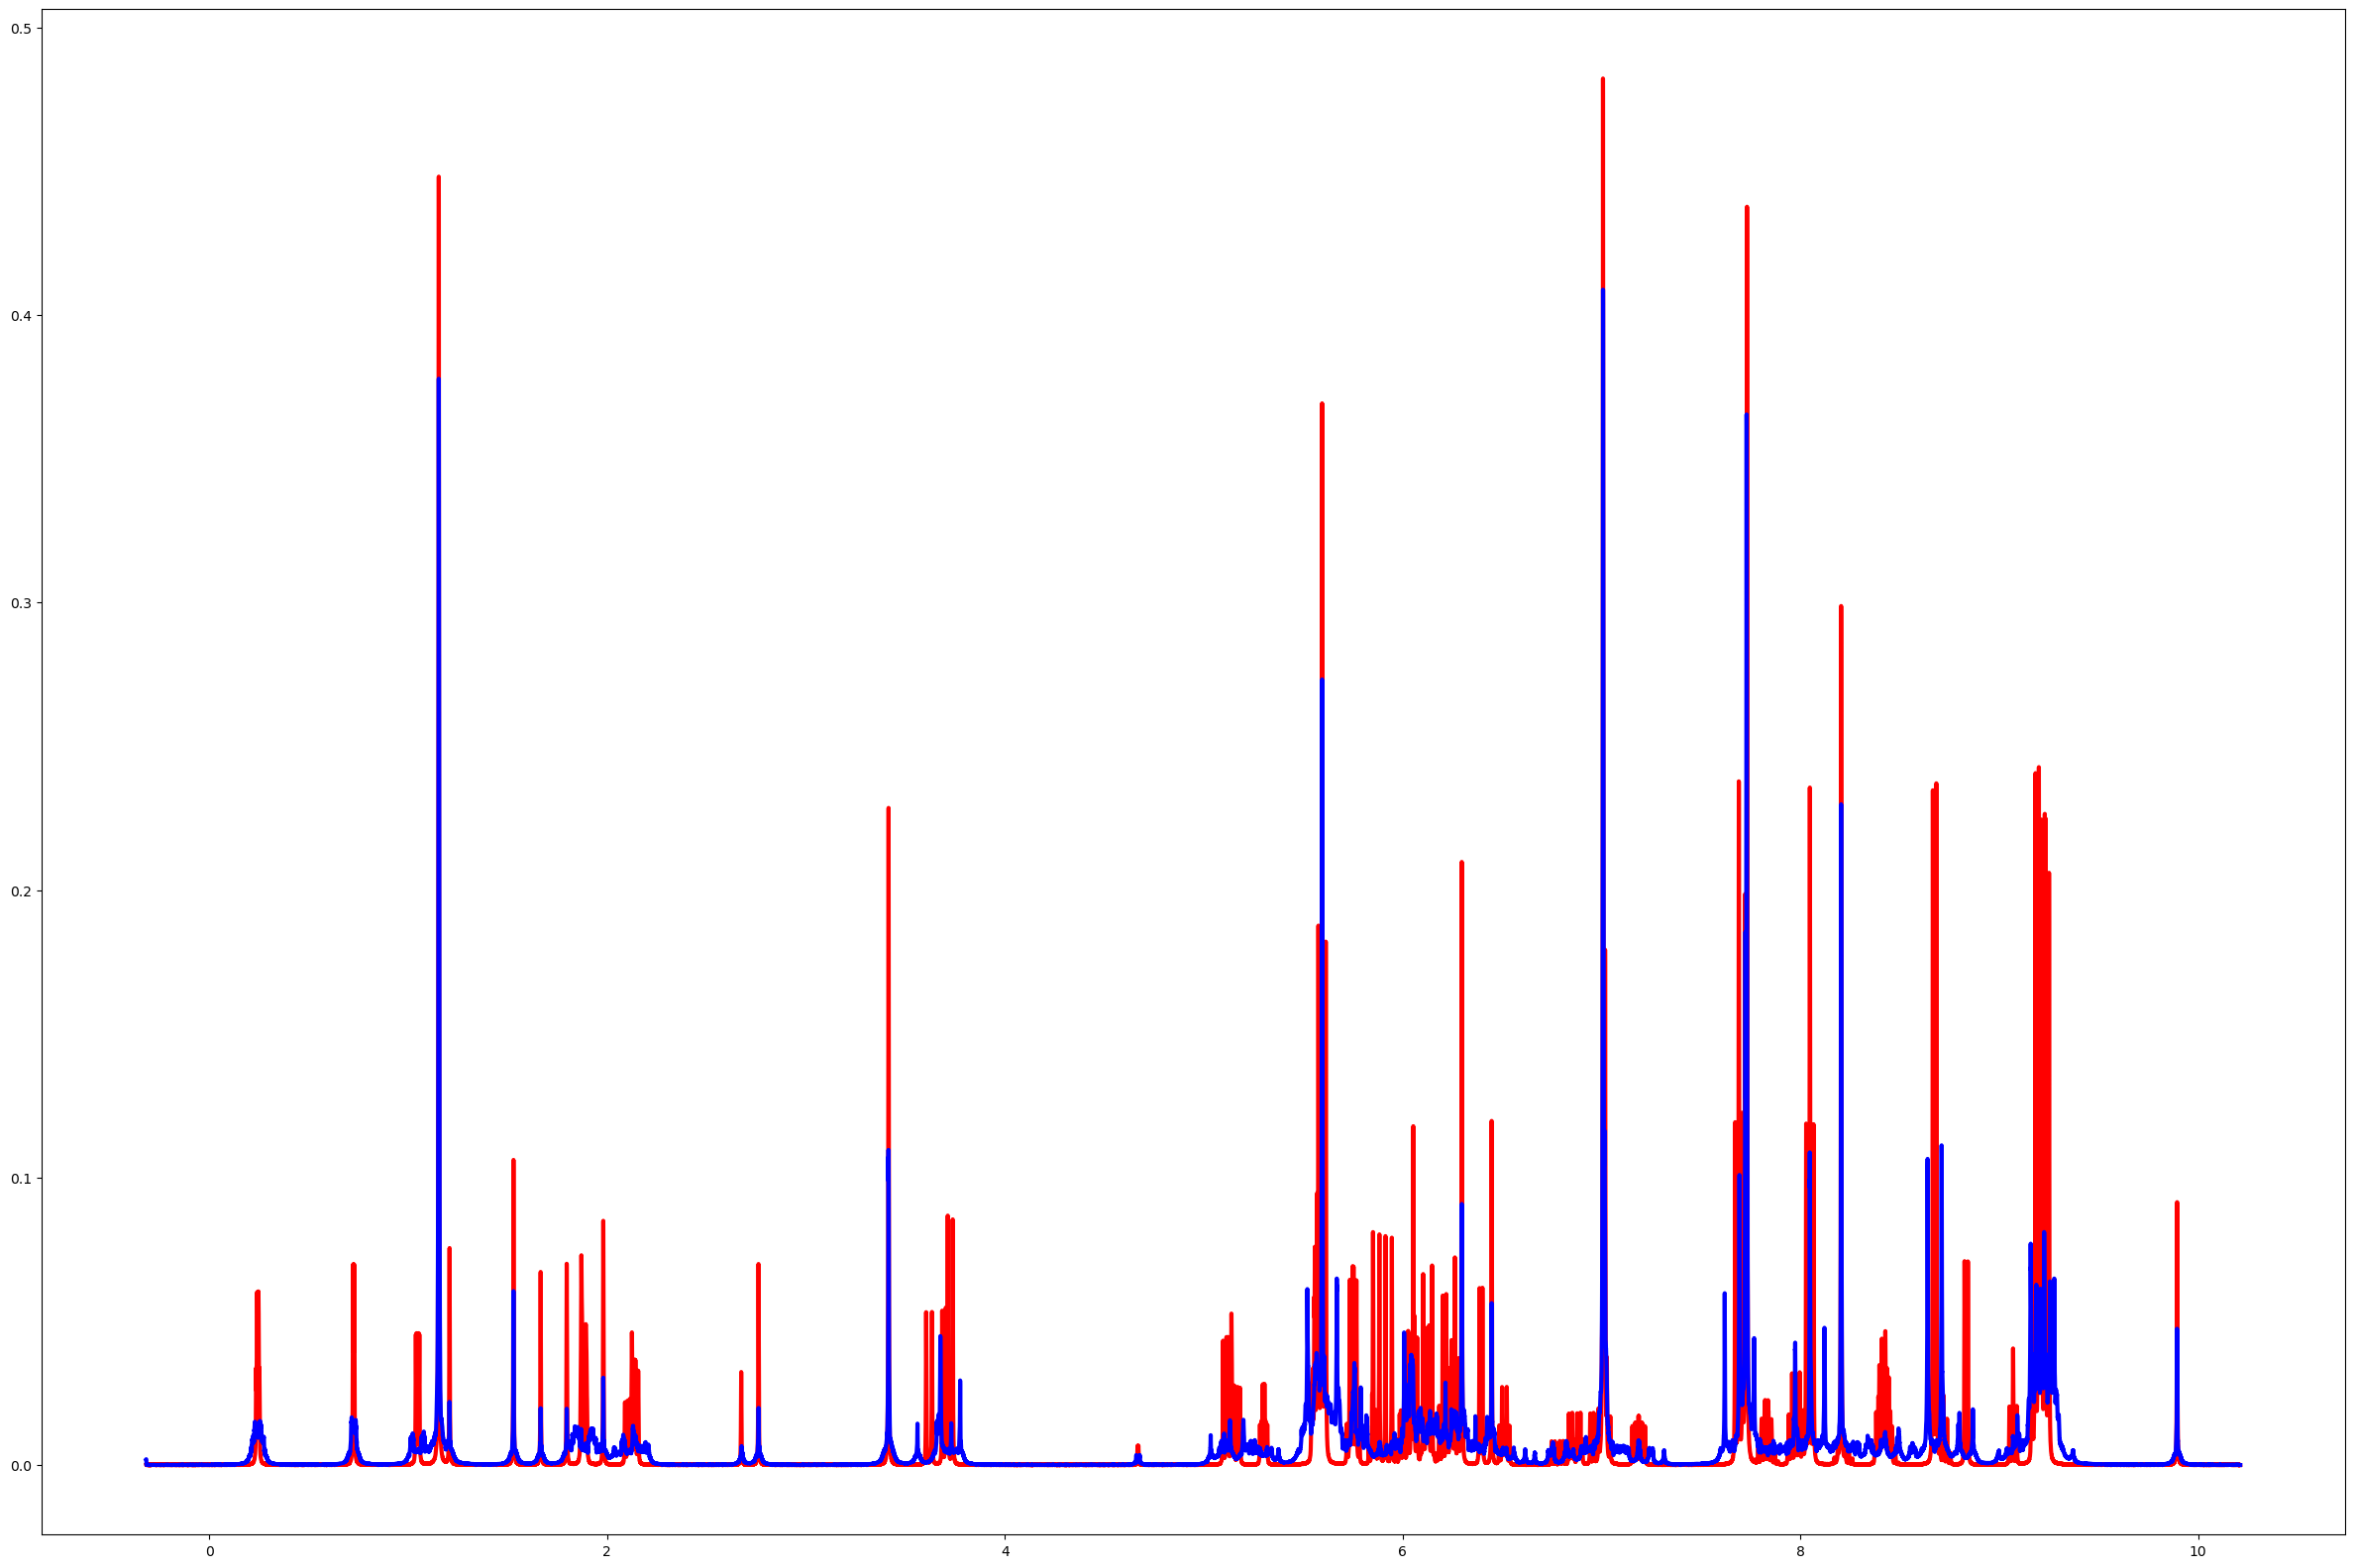

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


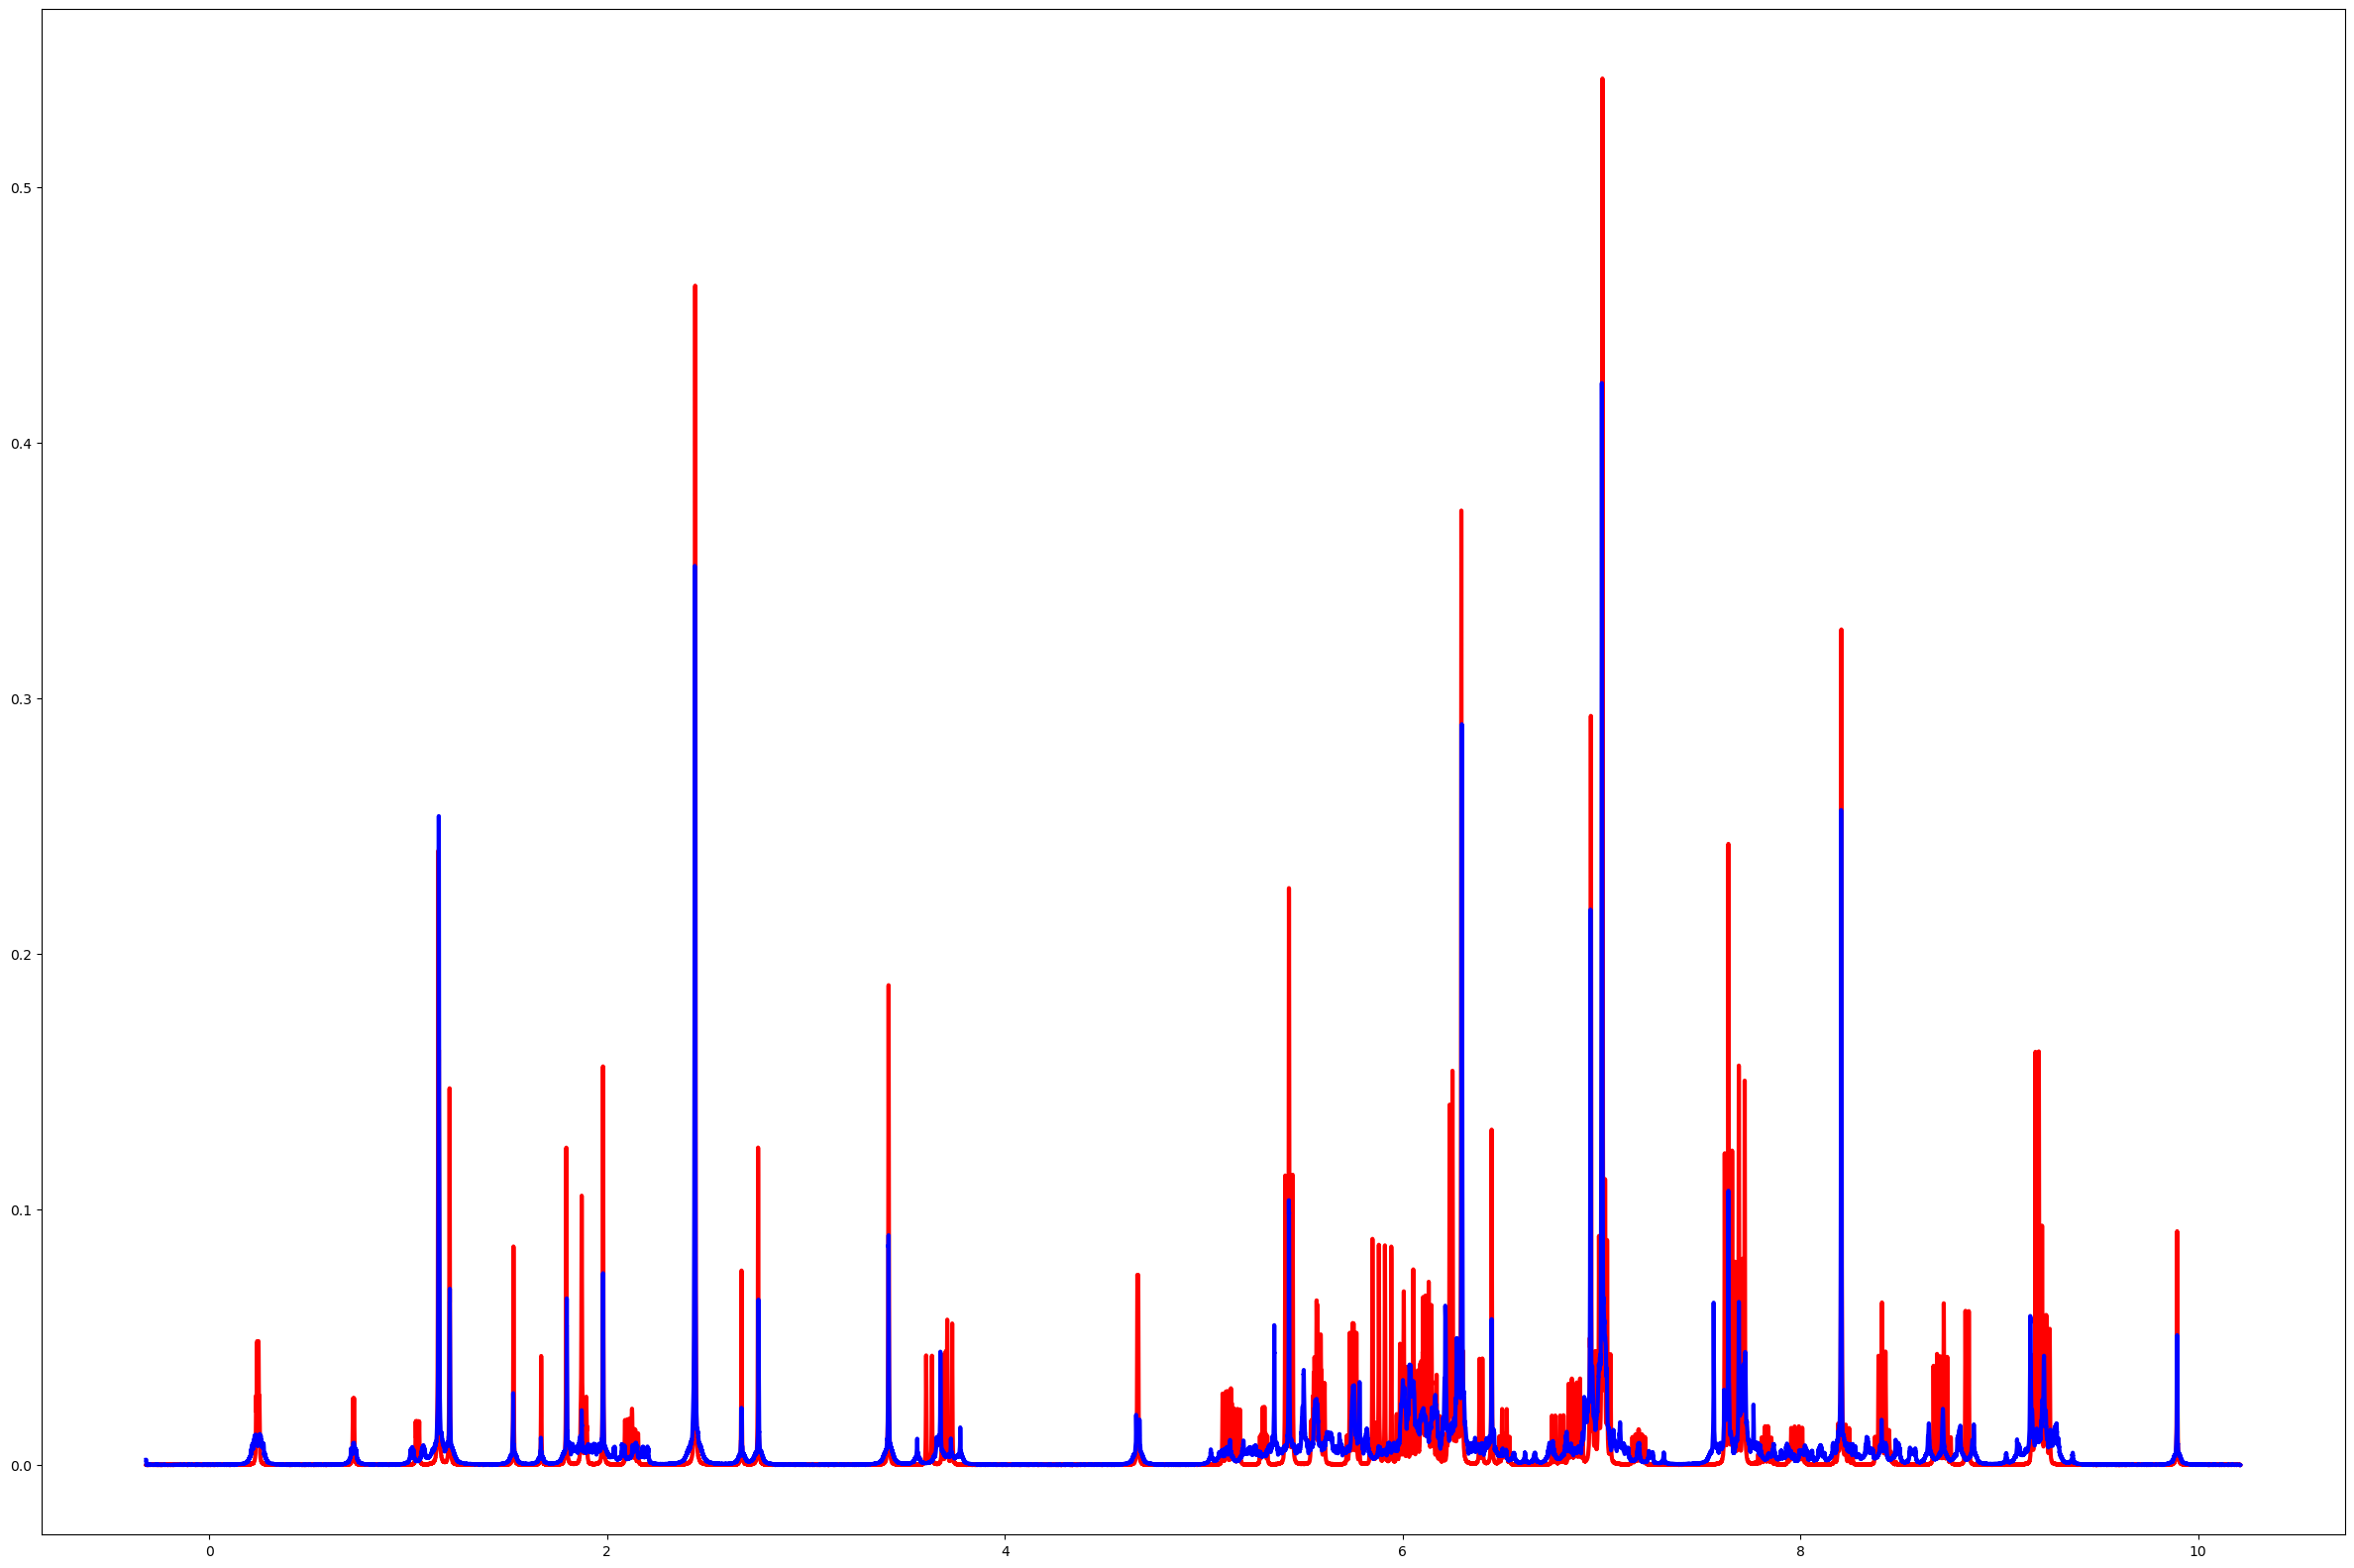

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


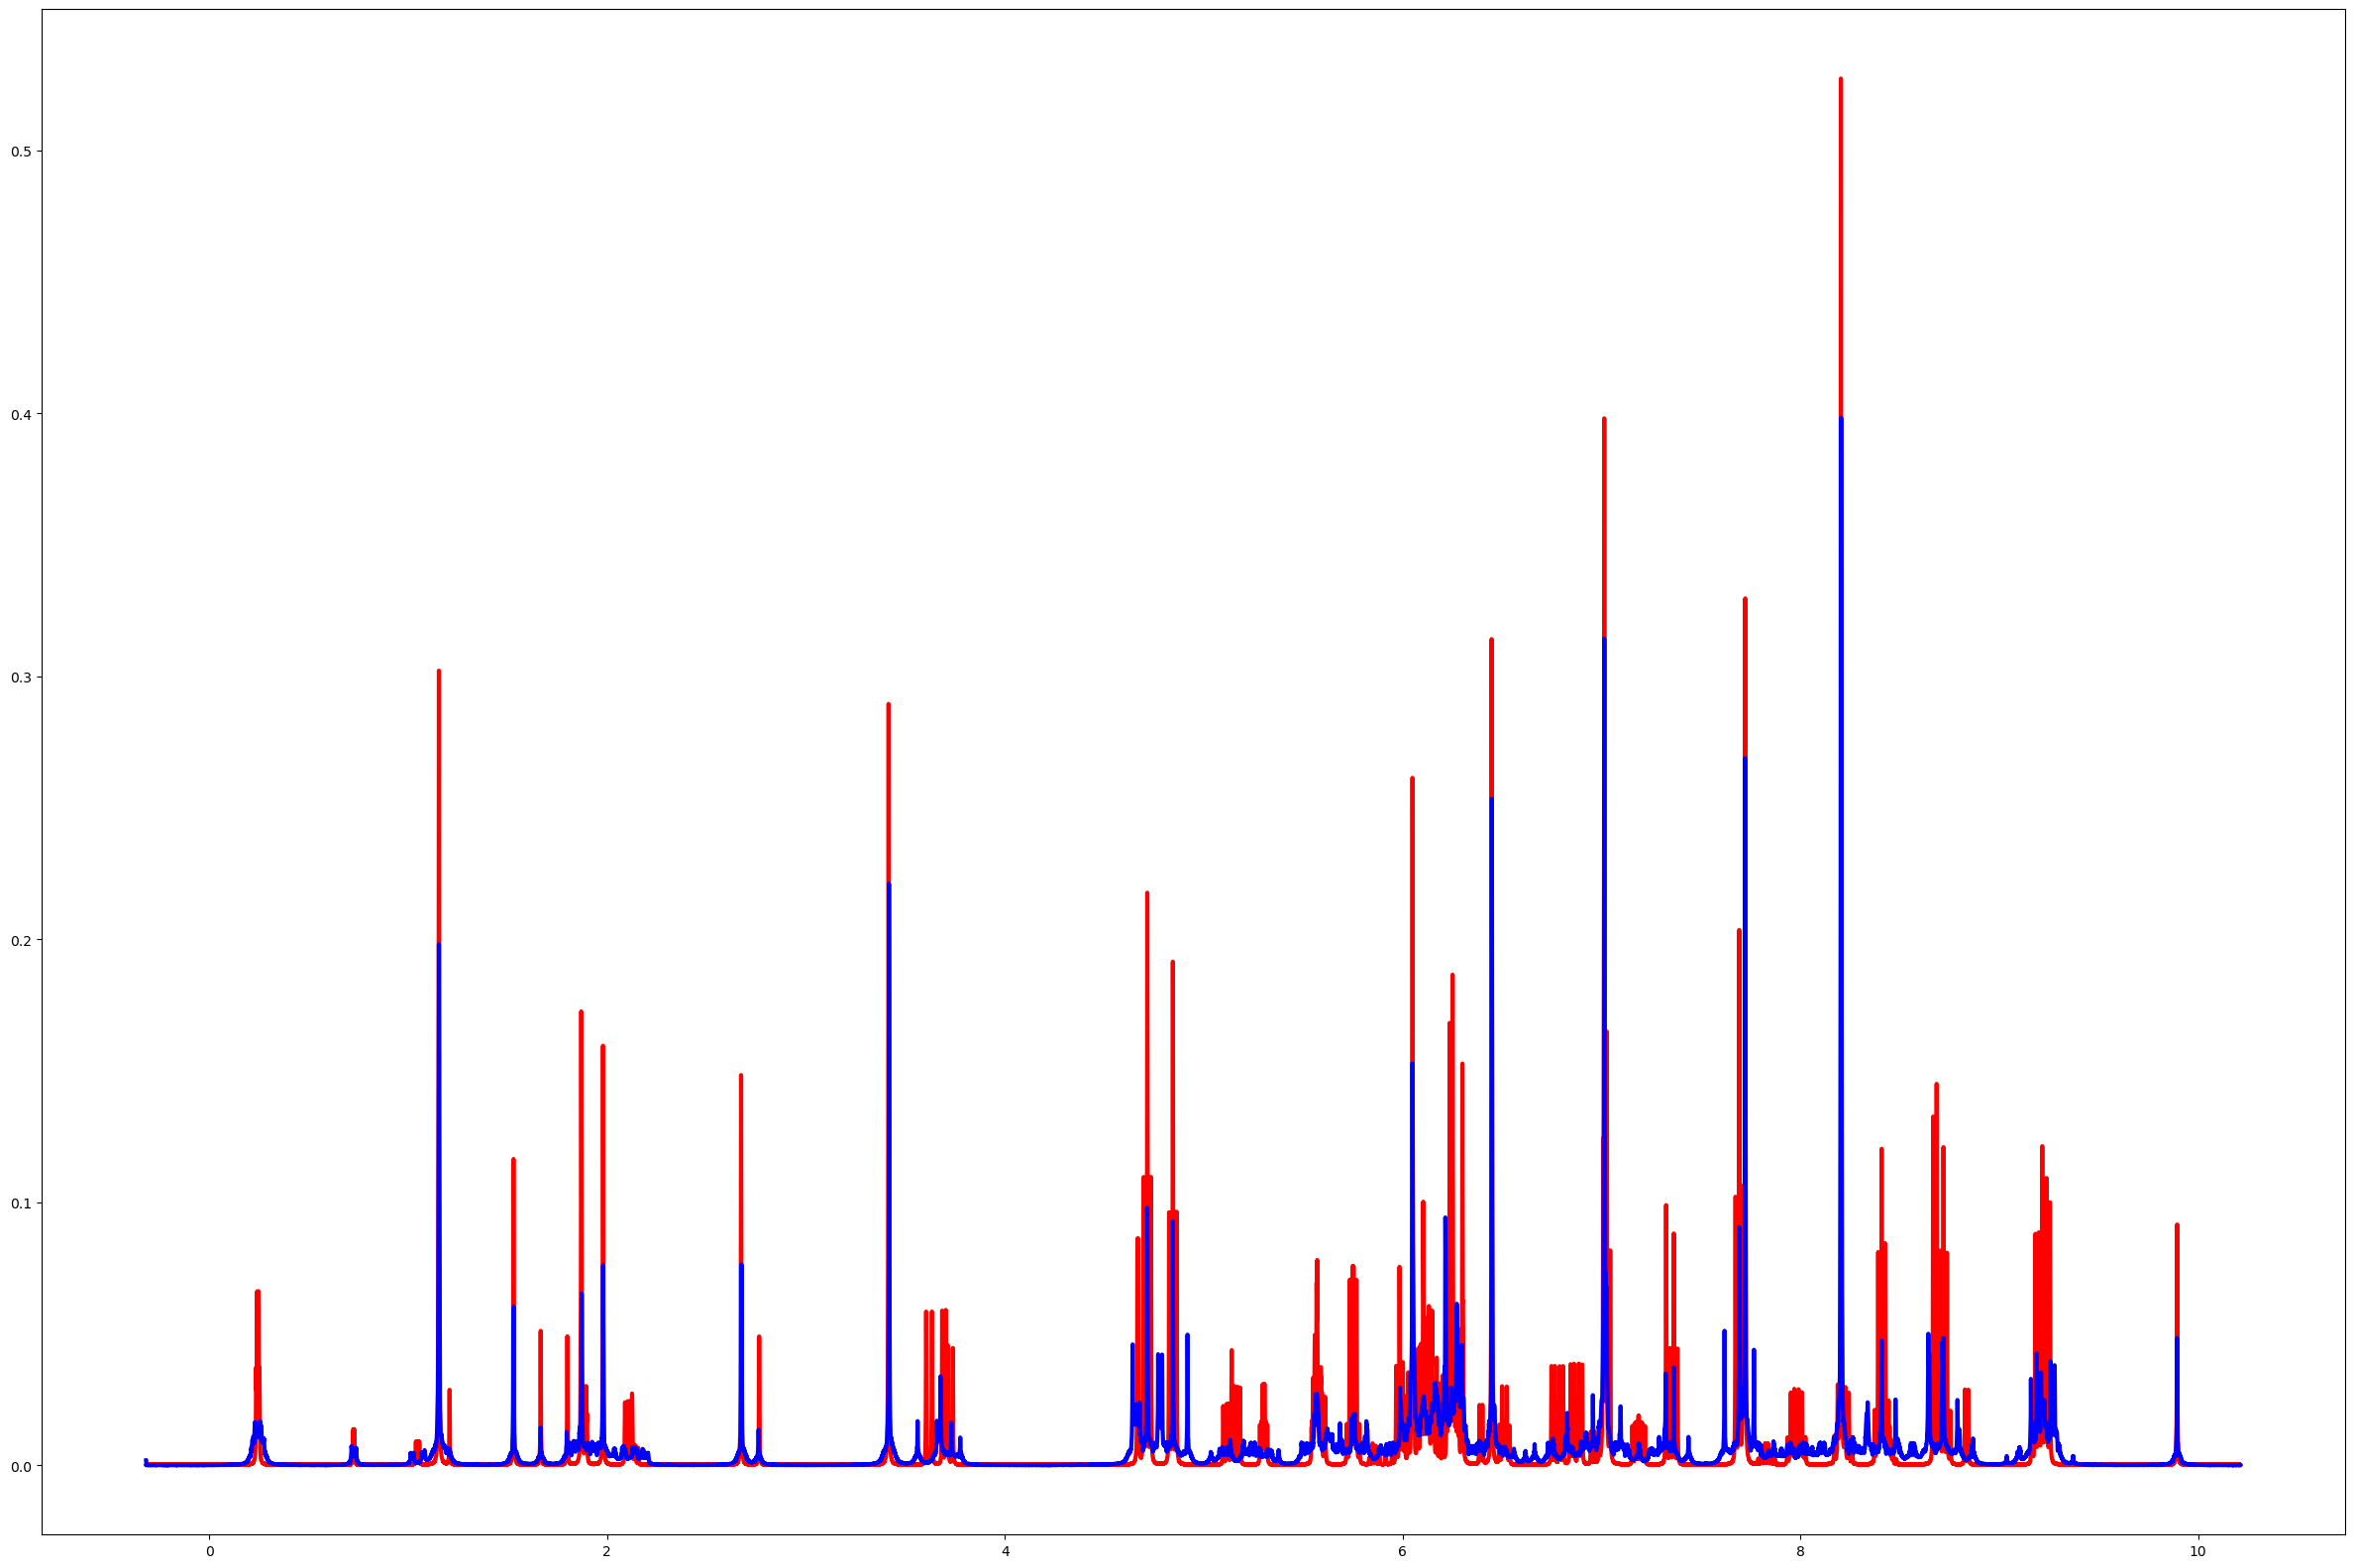

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


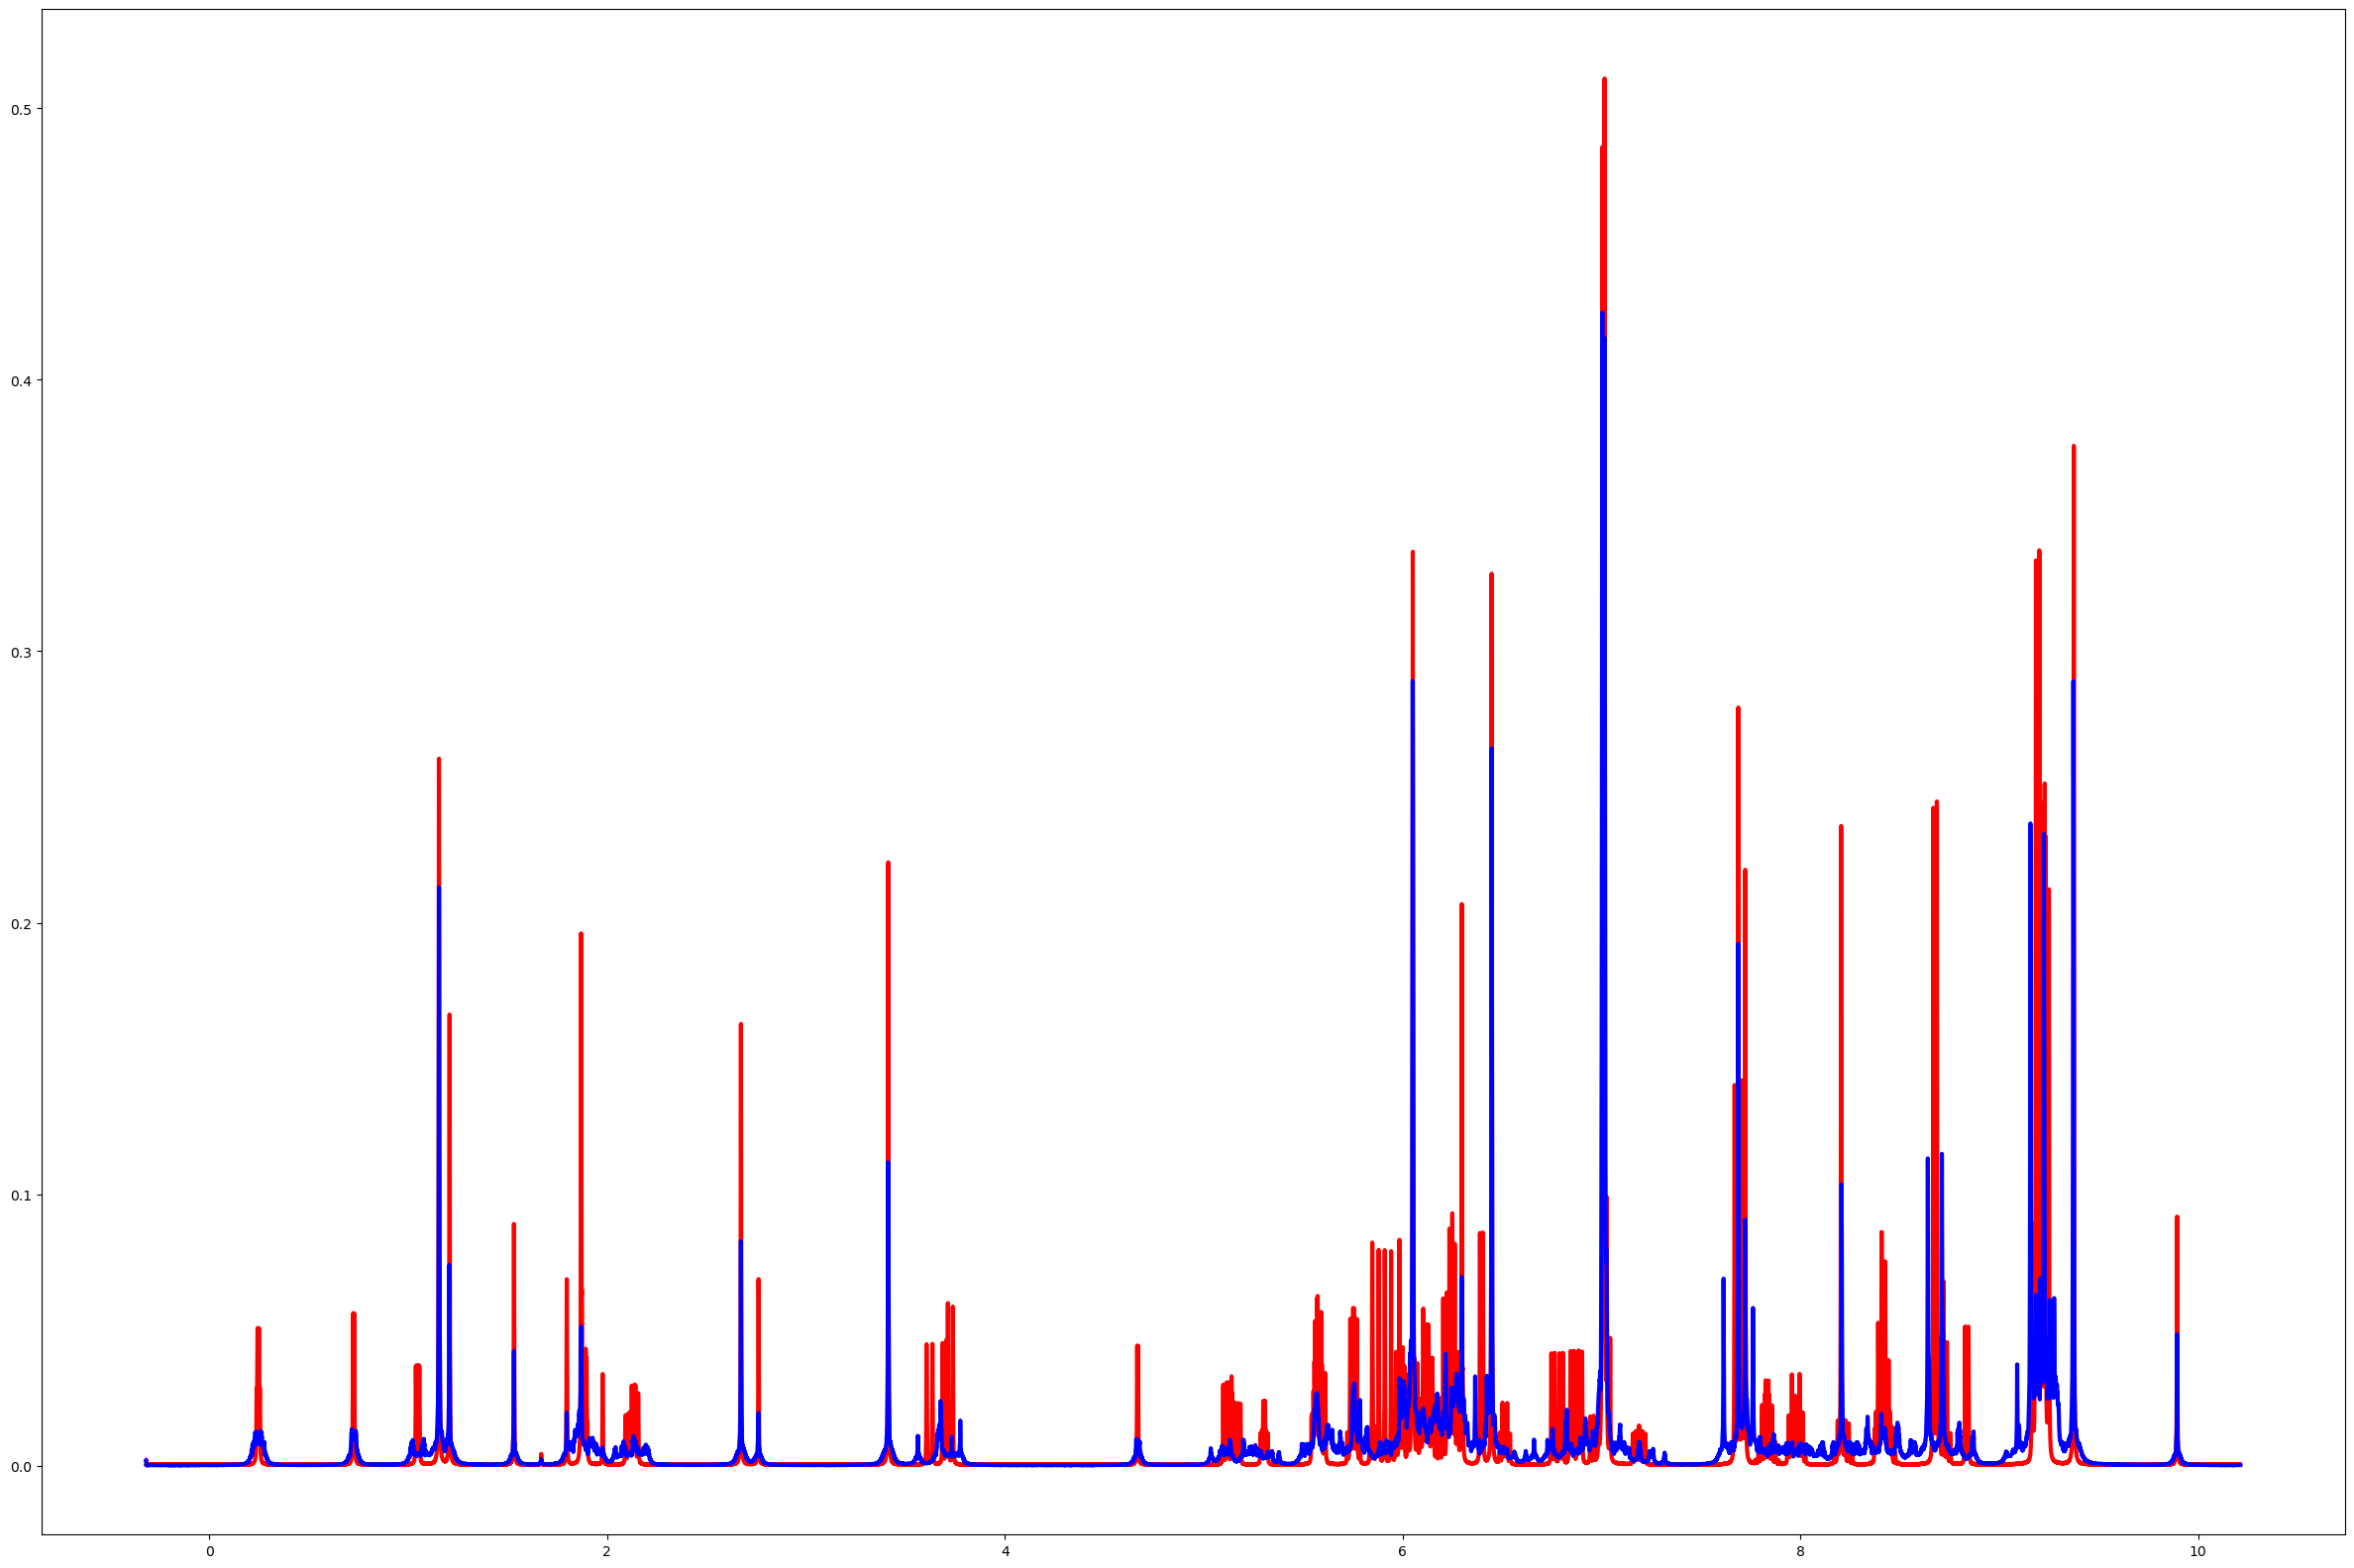

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


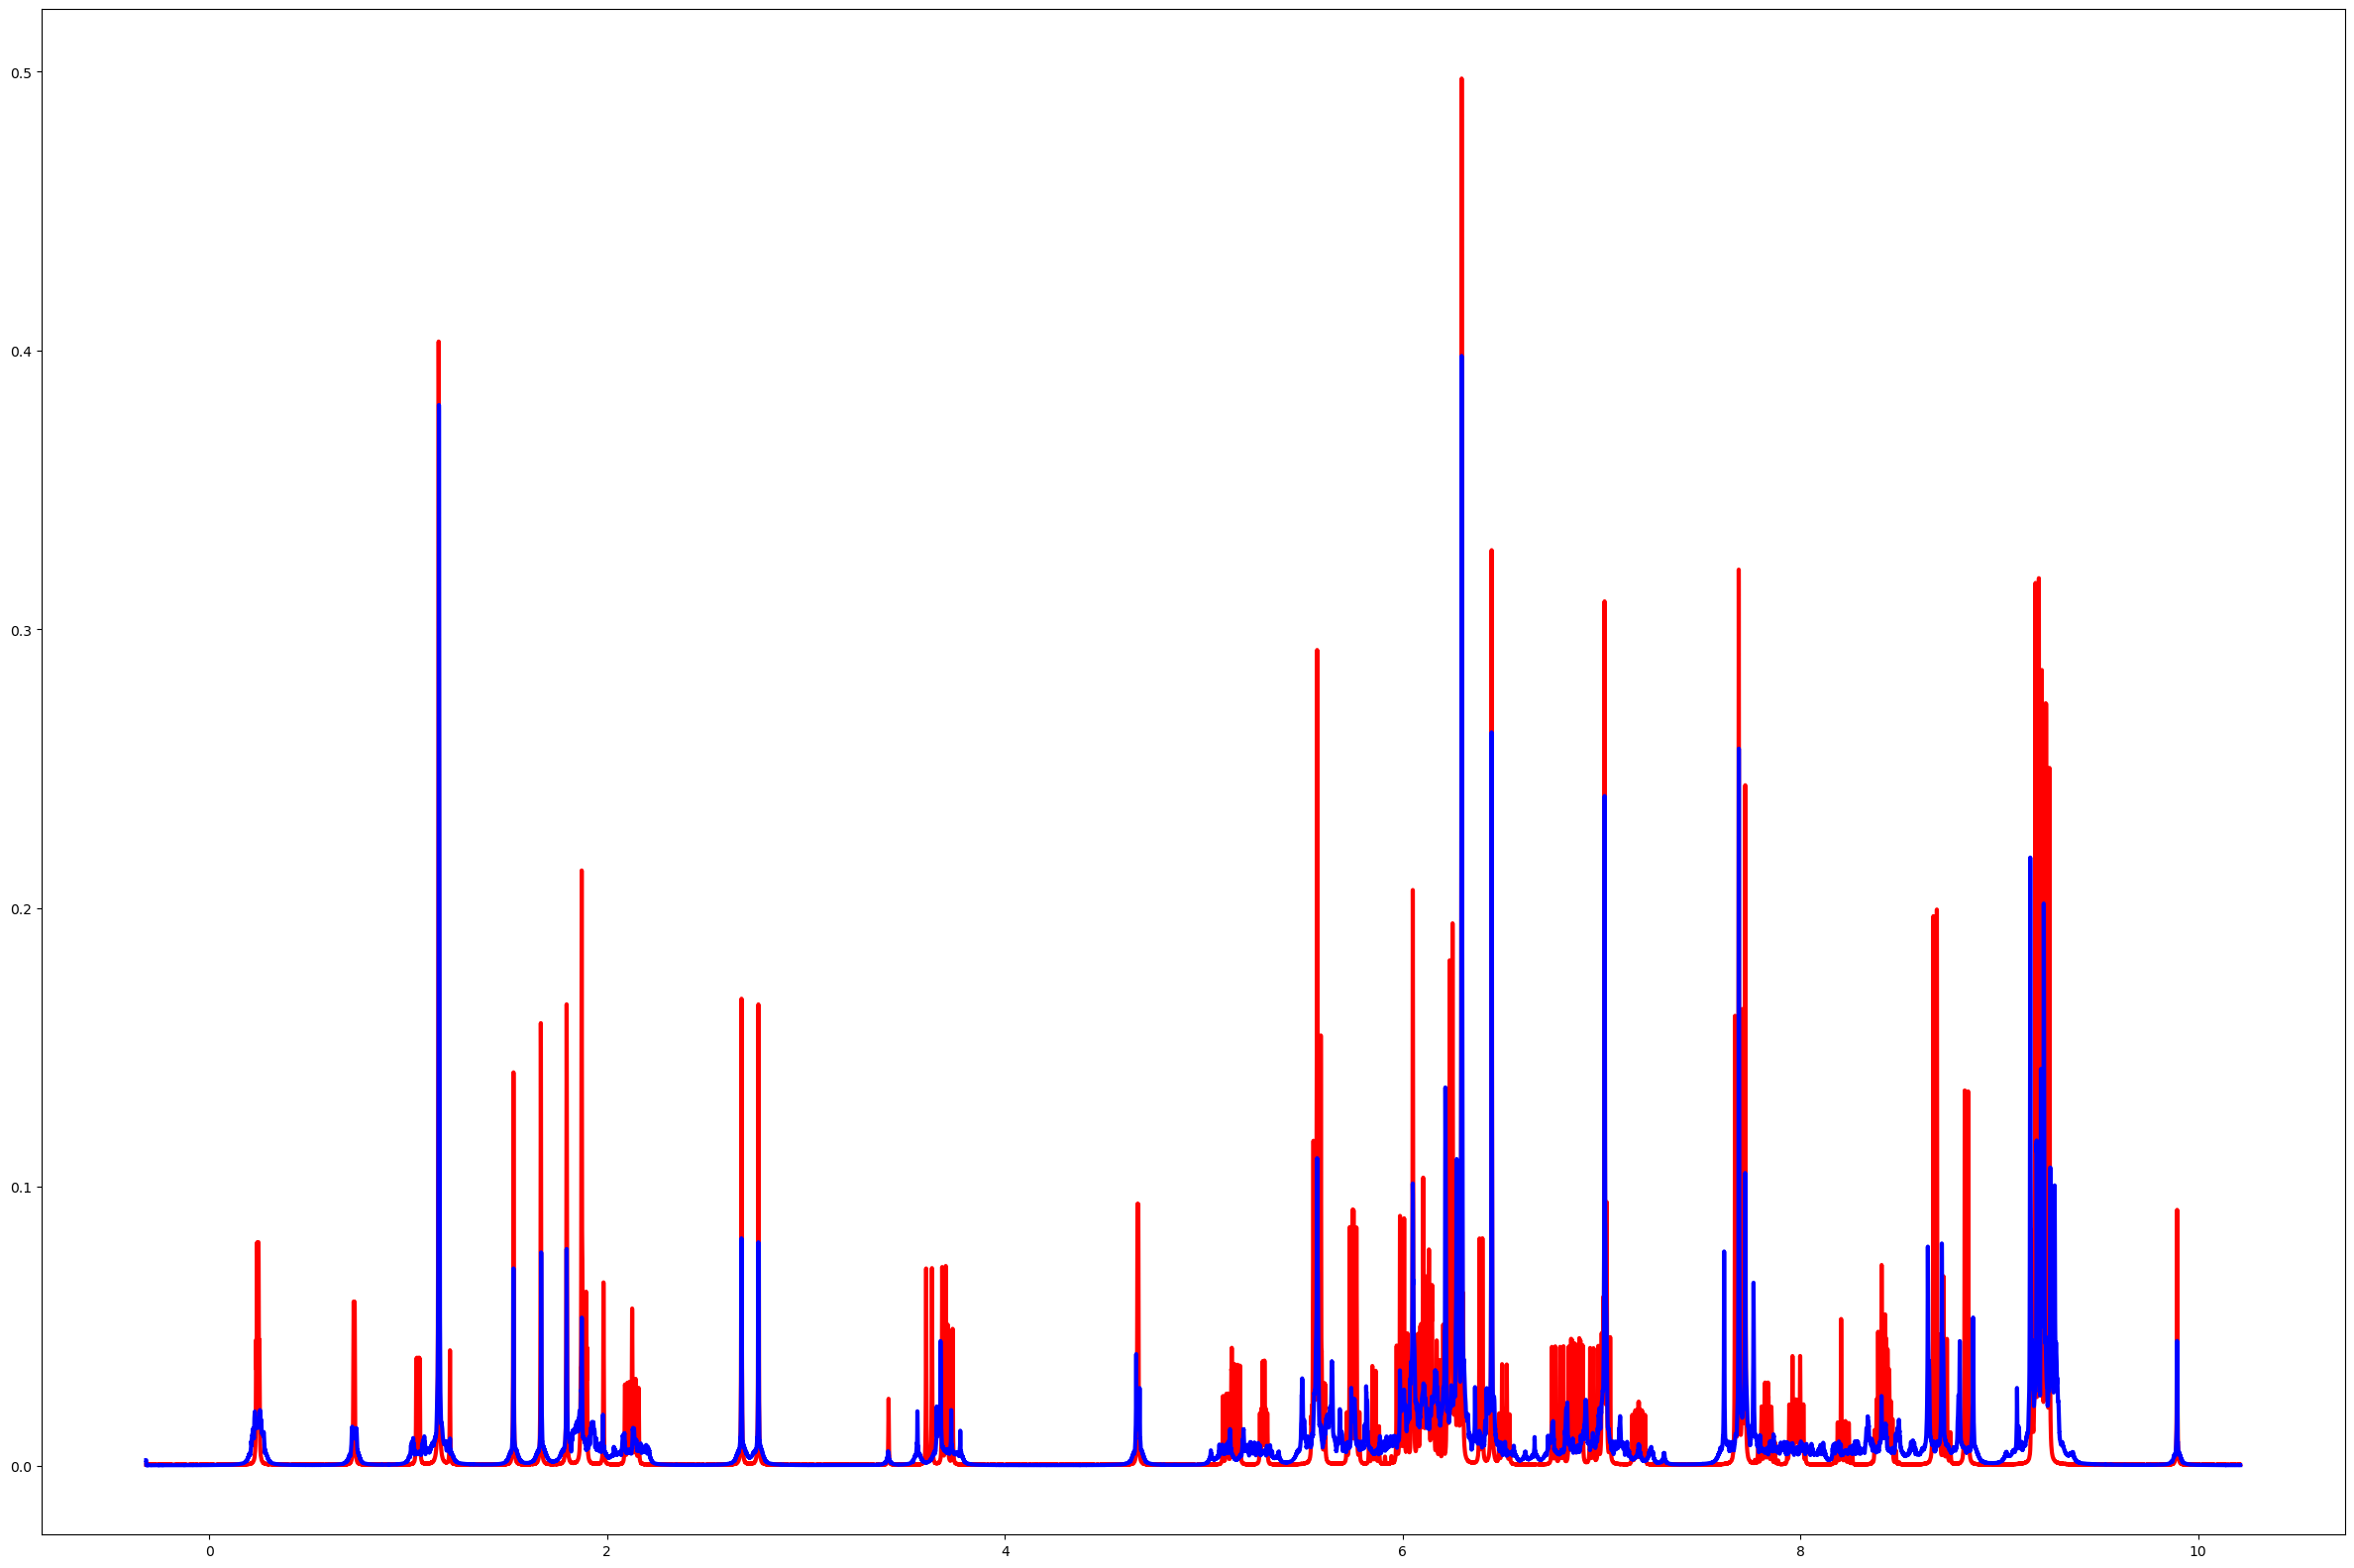

tensor(0.0003, device='cuda:0', grad_fn=<MseLossBackward0>)


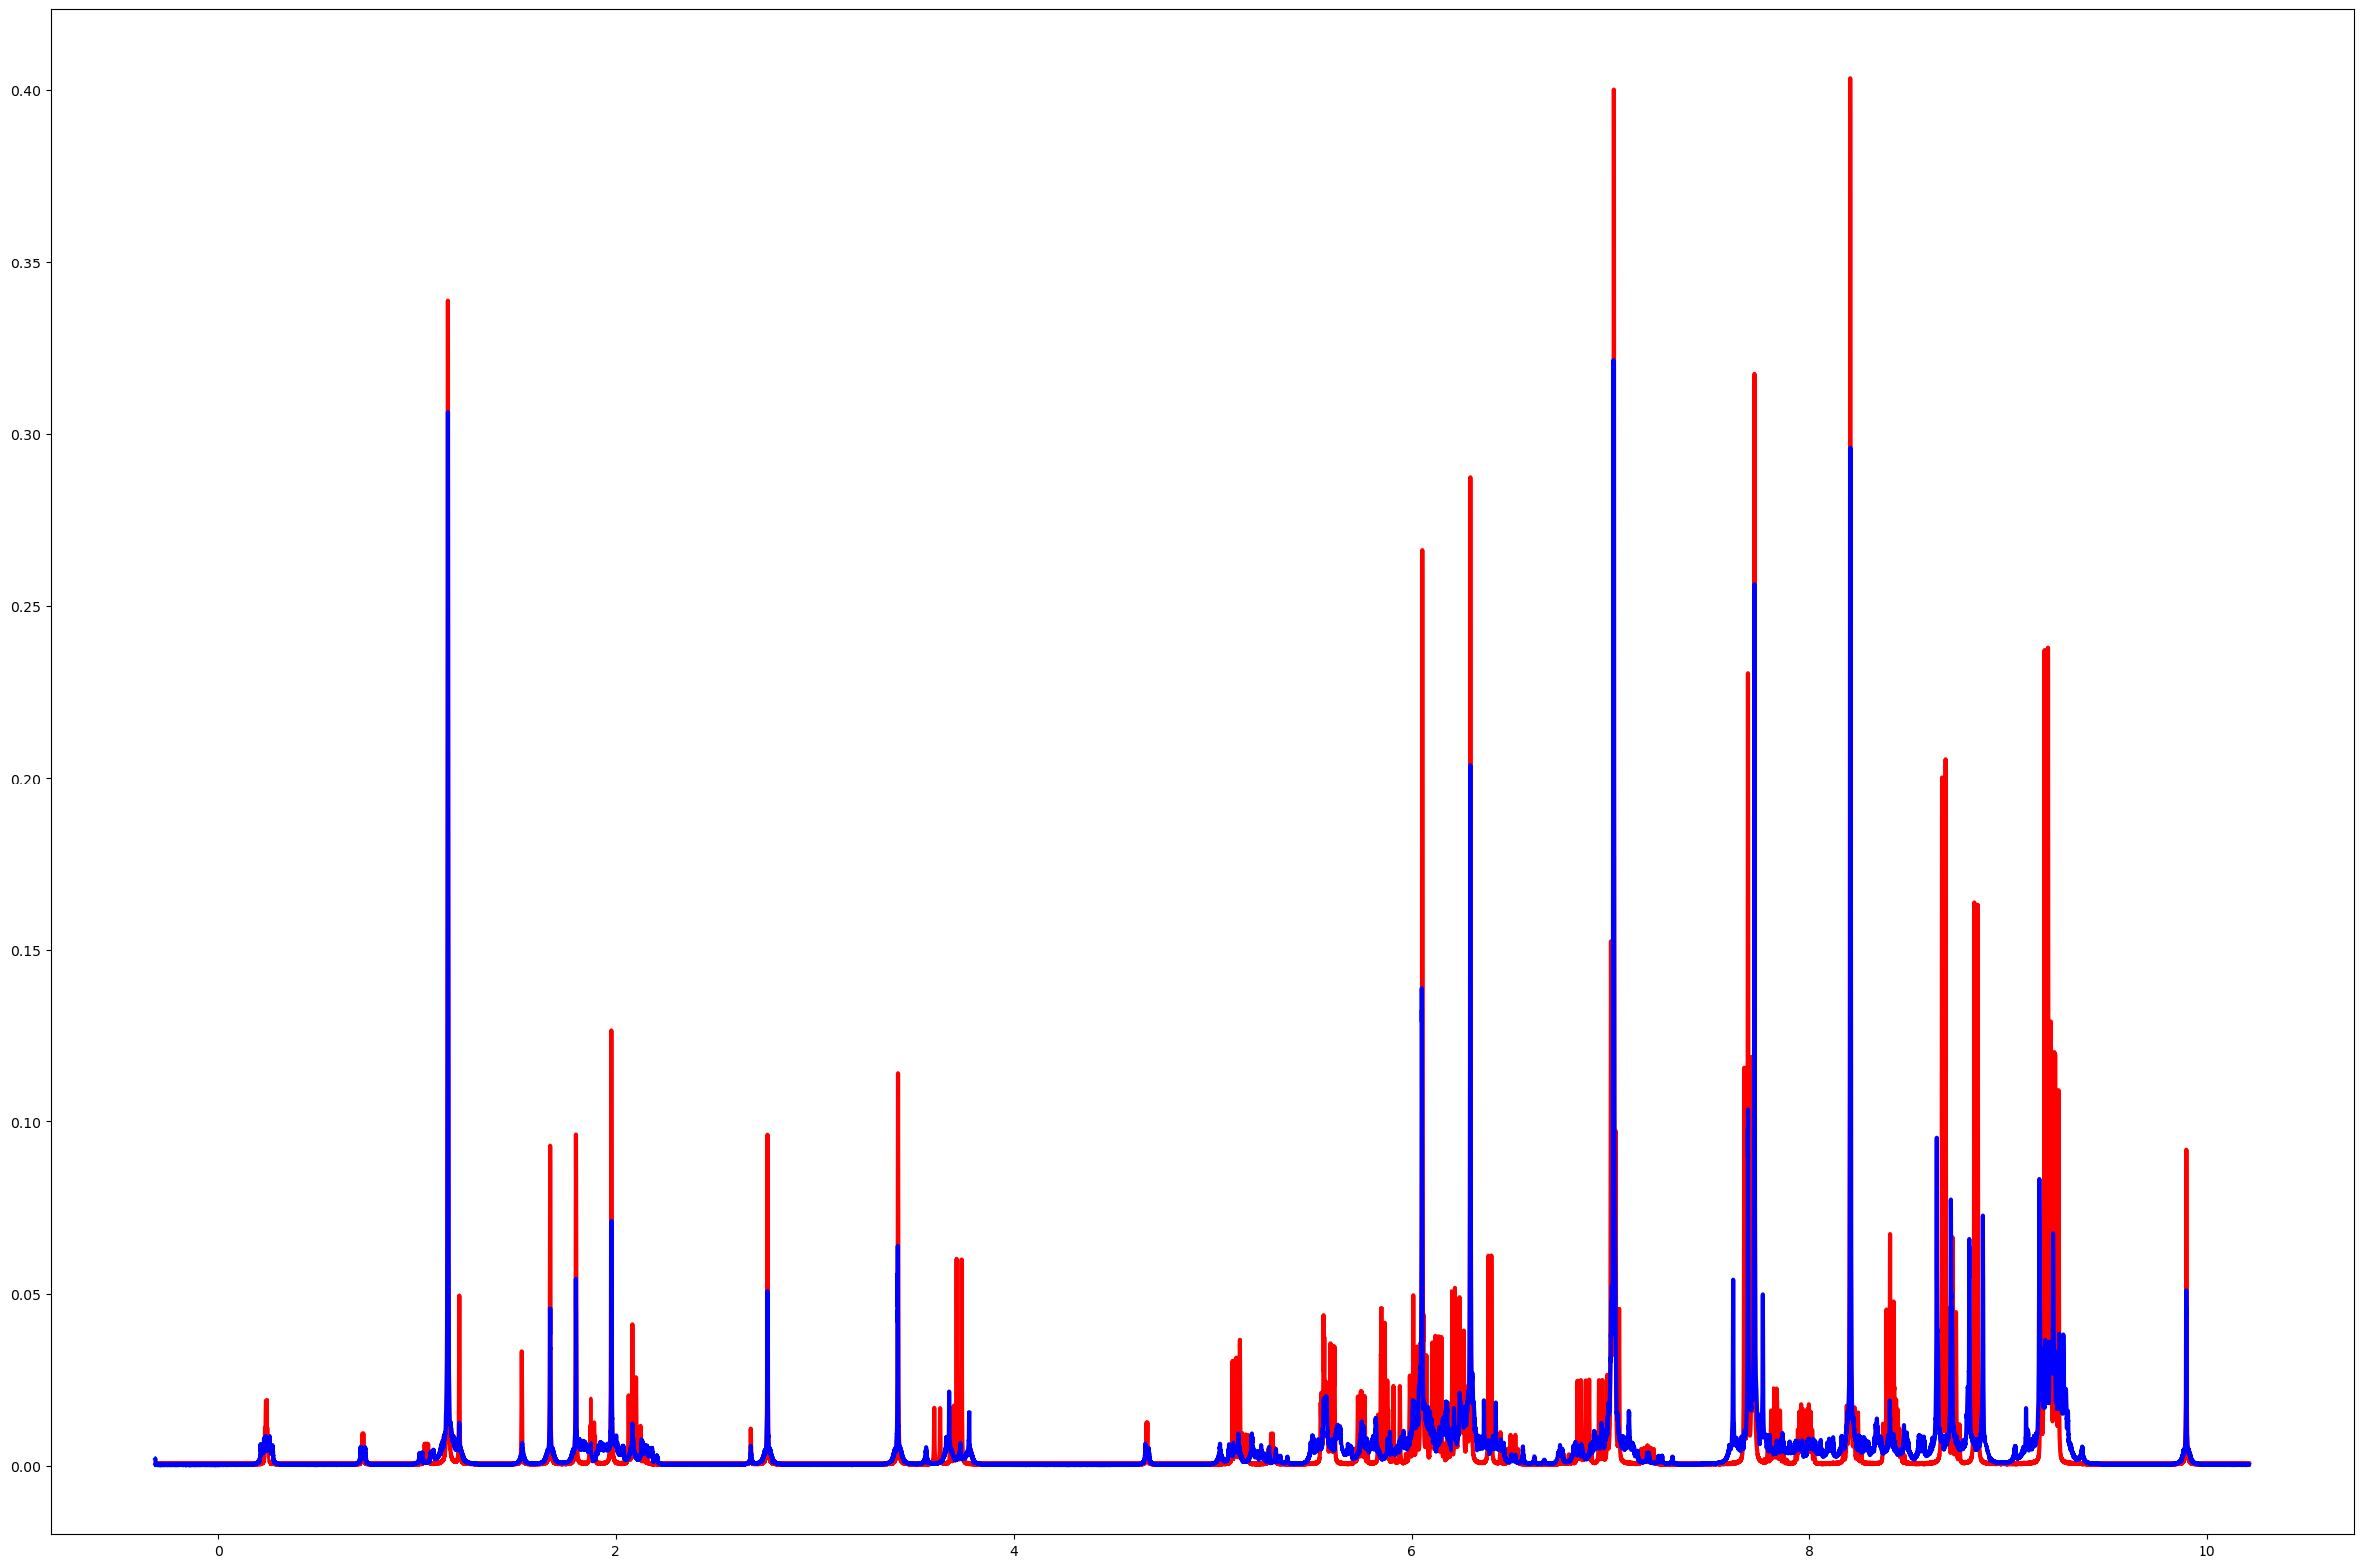

tensor(0.0001, device='cuda:0', grad_fn=<MseLossBackward0>)


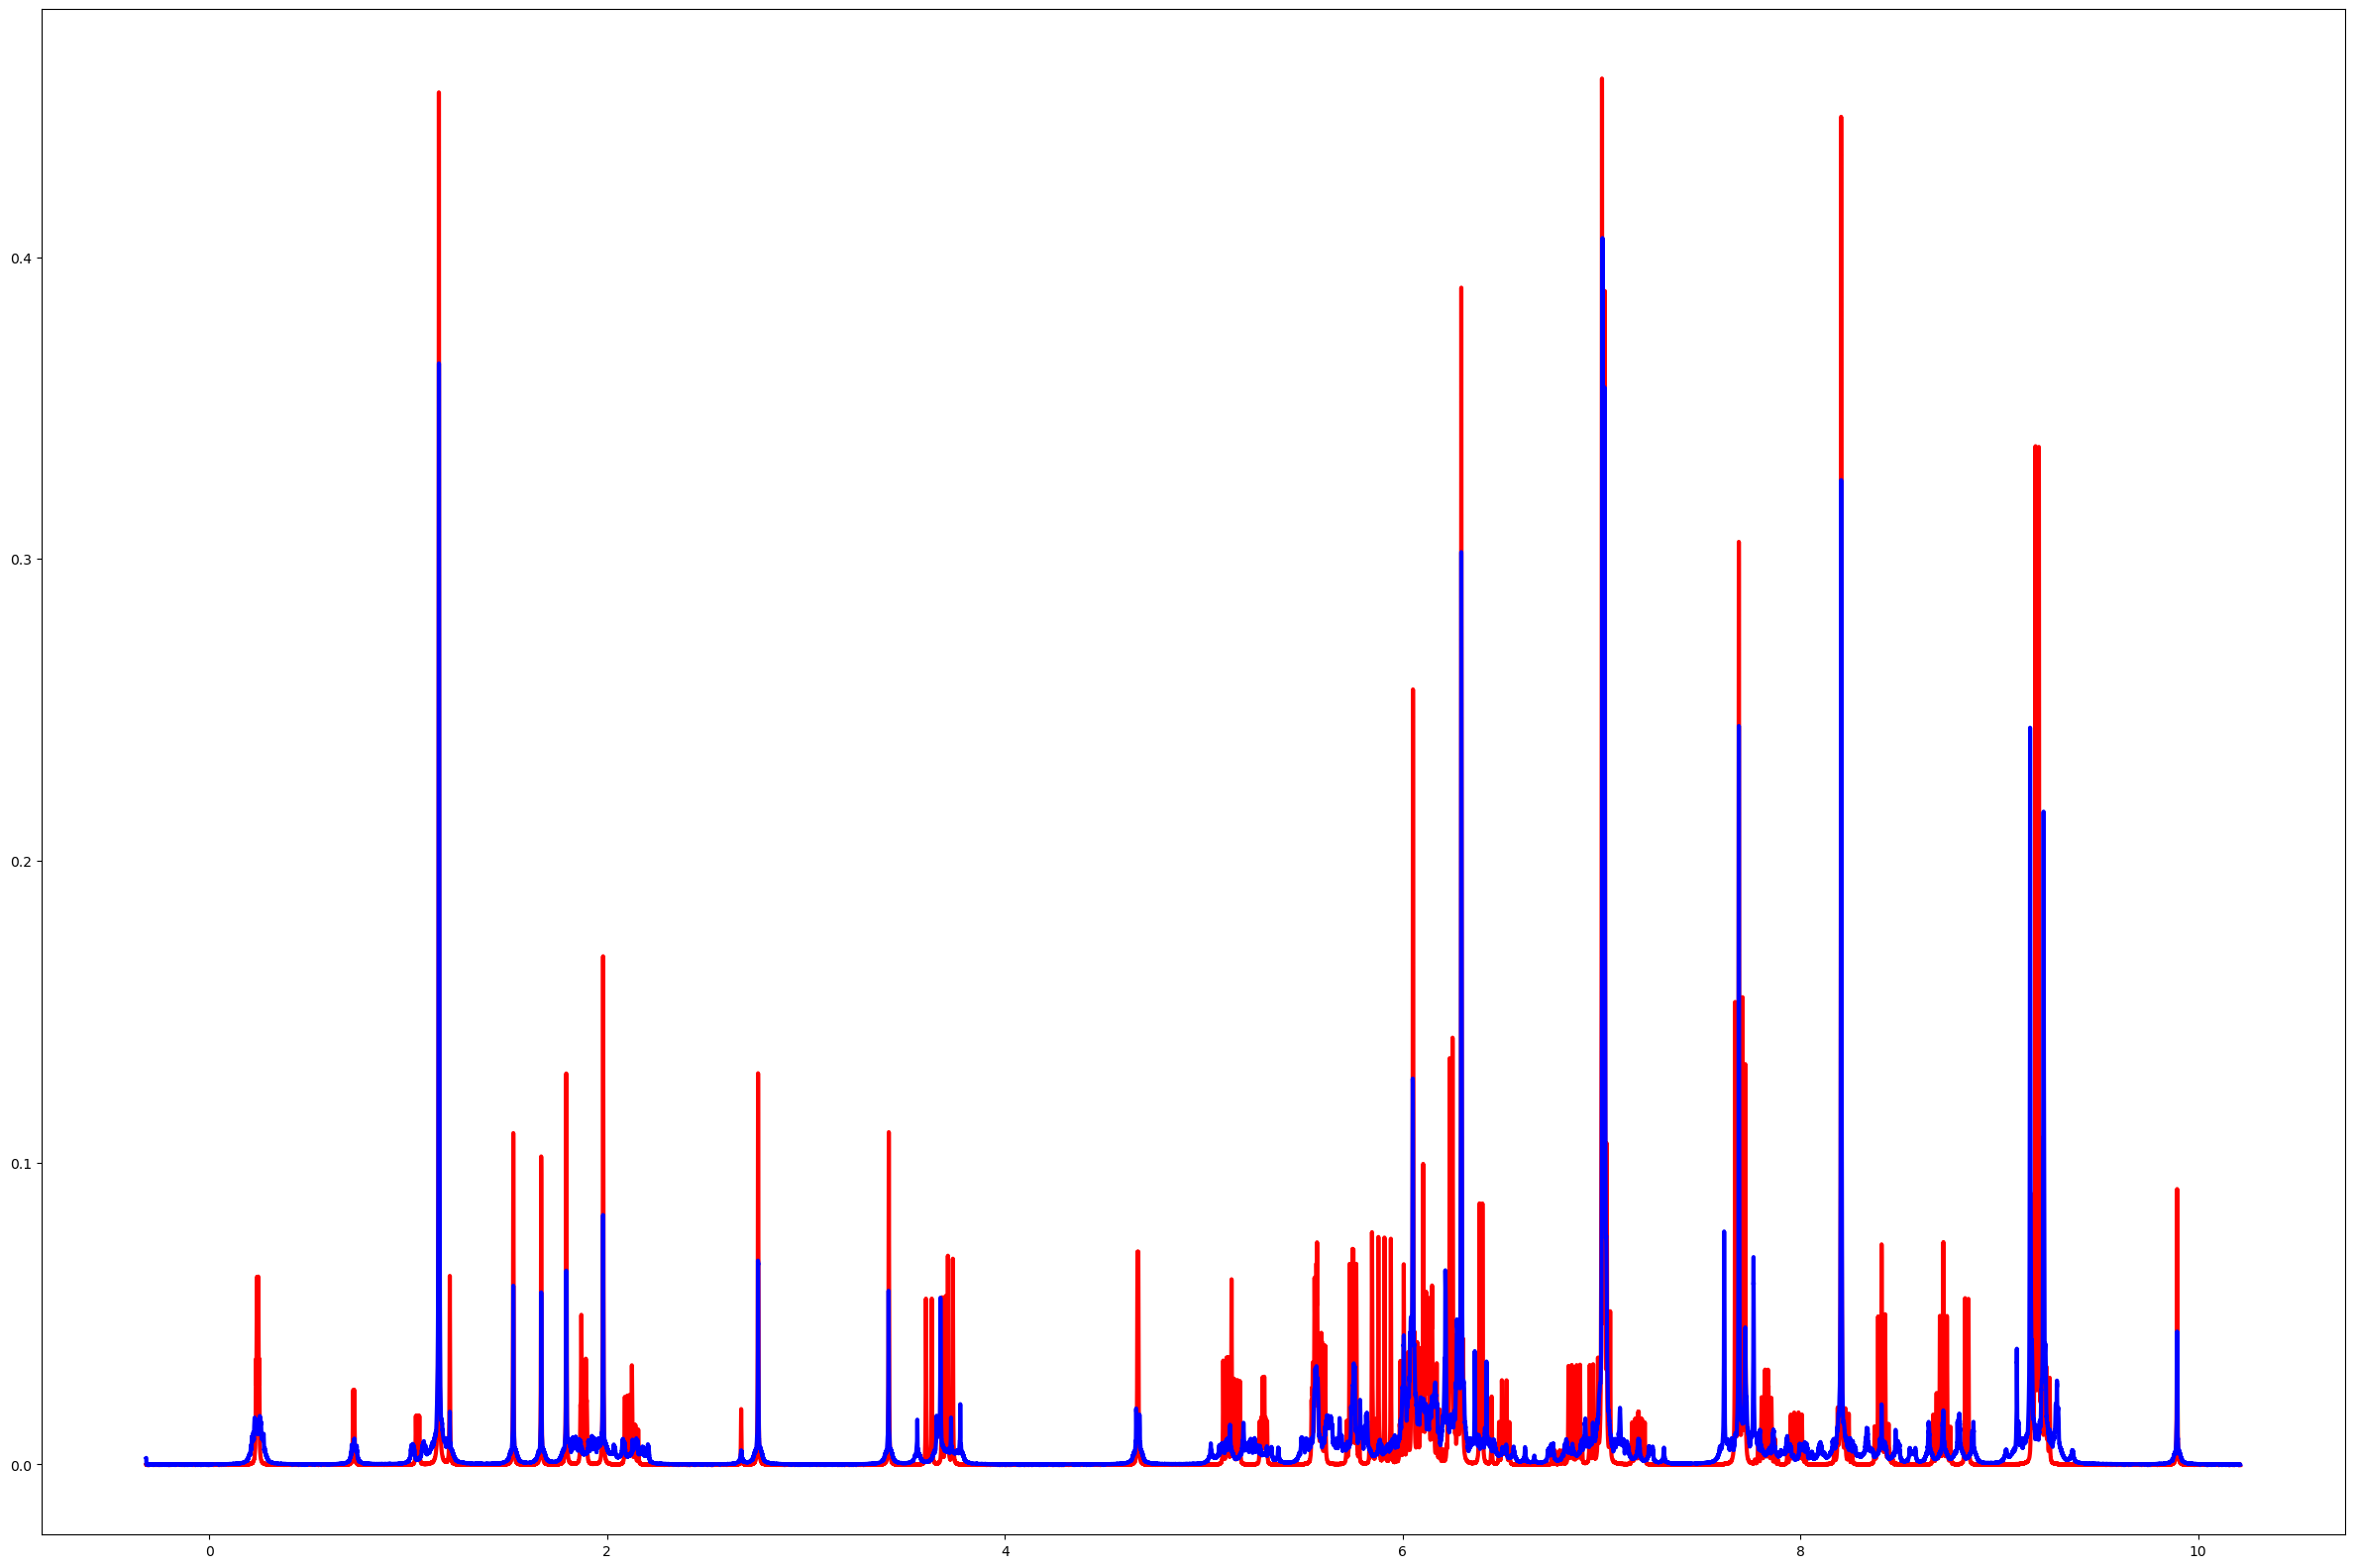

tensor(0.0002, device='cuda:0', grad_fn=<MseLossBackward0>)


In [11]:

LF = spectraVal100[:10]
GT = spectraVal400[:10]
criterion = nn.MSELoss()
model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF.unsqueeze(1)).cpu().detach().numpy()

for i in np.arange(10):
    plt.plot(np.flip(ppm), GT[i].cpu().detach().numpy(), color = 'red', linewidth = 3)
    plt.plot(np.flip(ppm), outputs[i][0], color = 'blue', linewidth = 3)
    plt.show()
    print(criterion(model(LF.unsqueeze(1))[i], GT[i]))

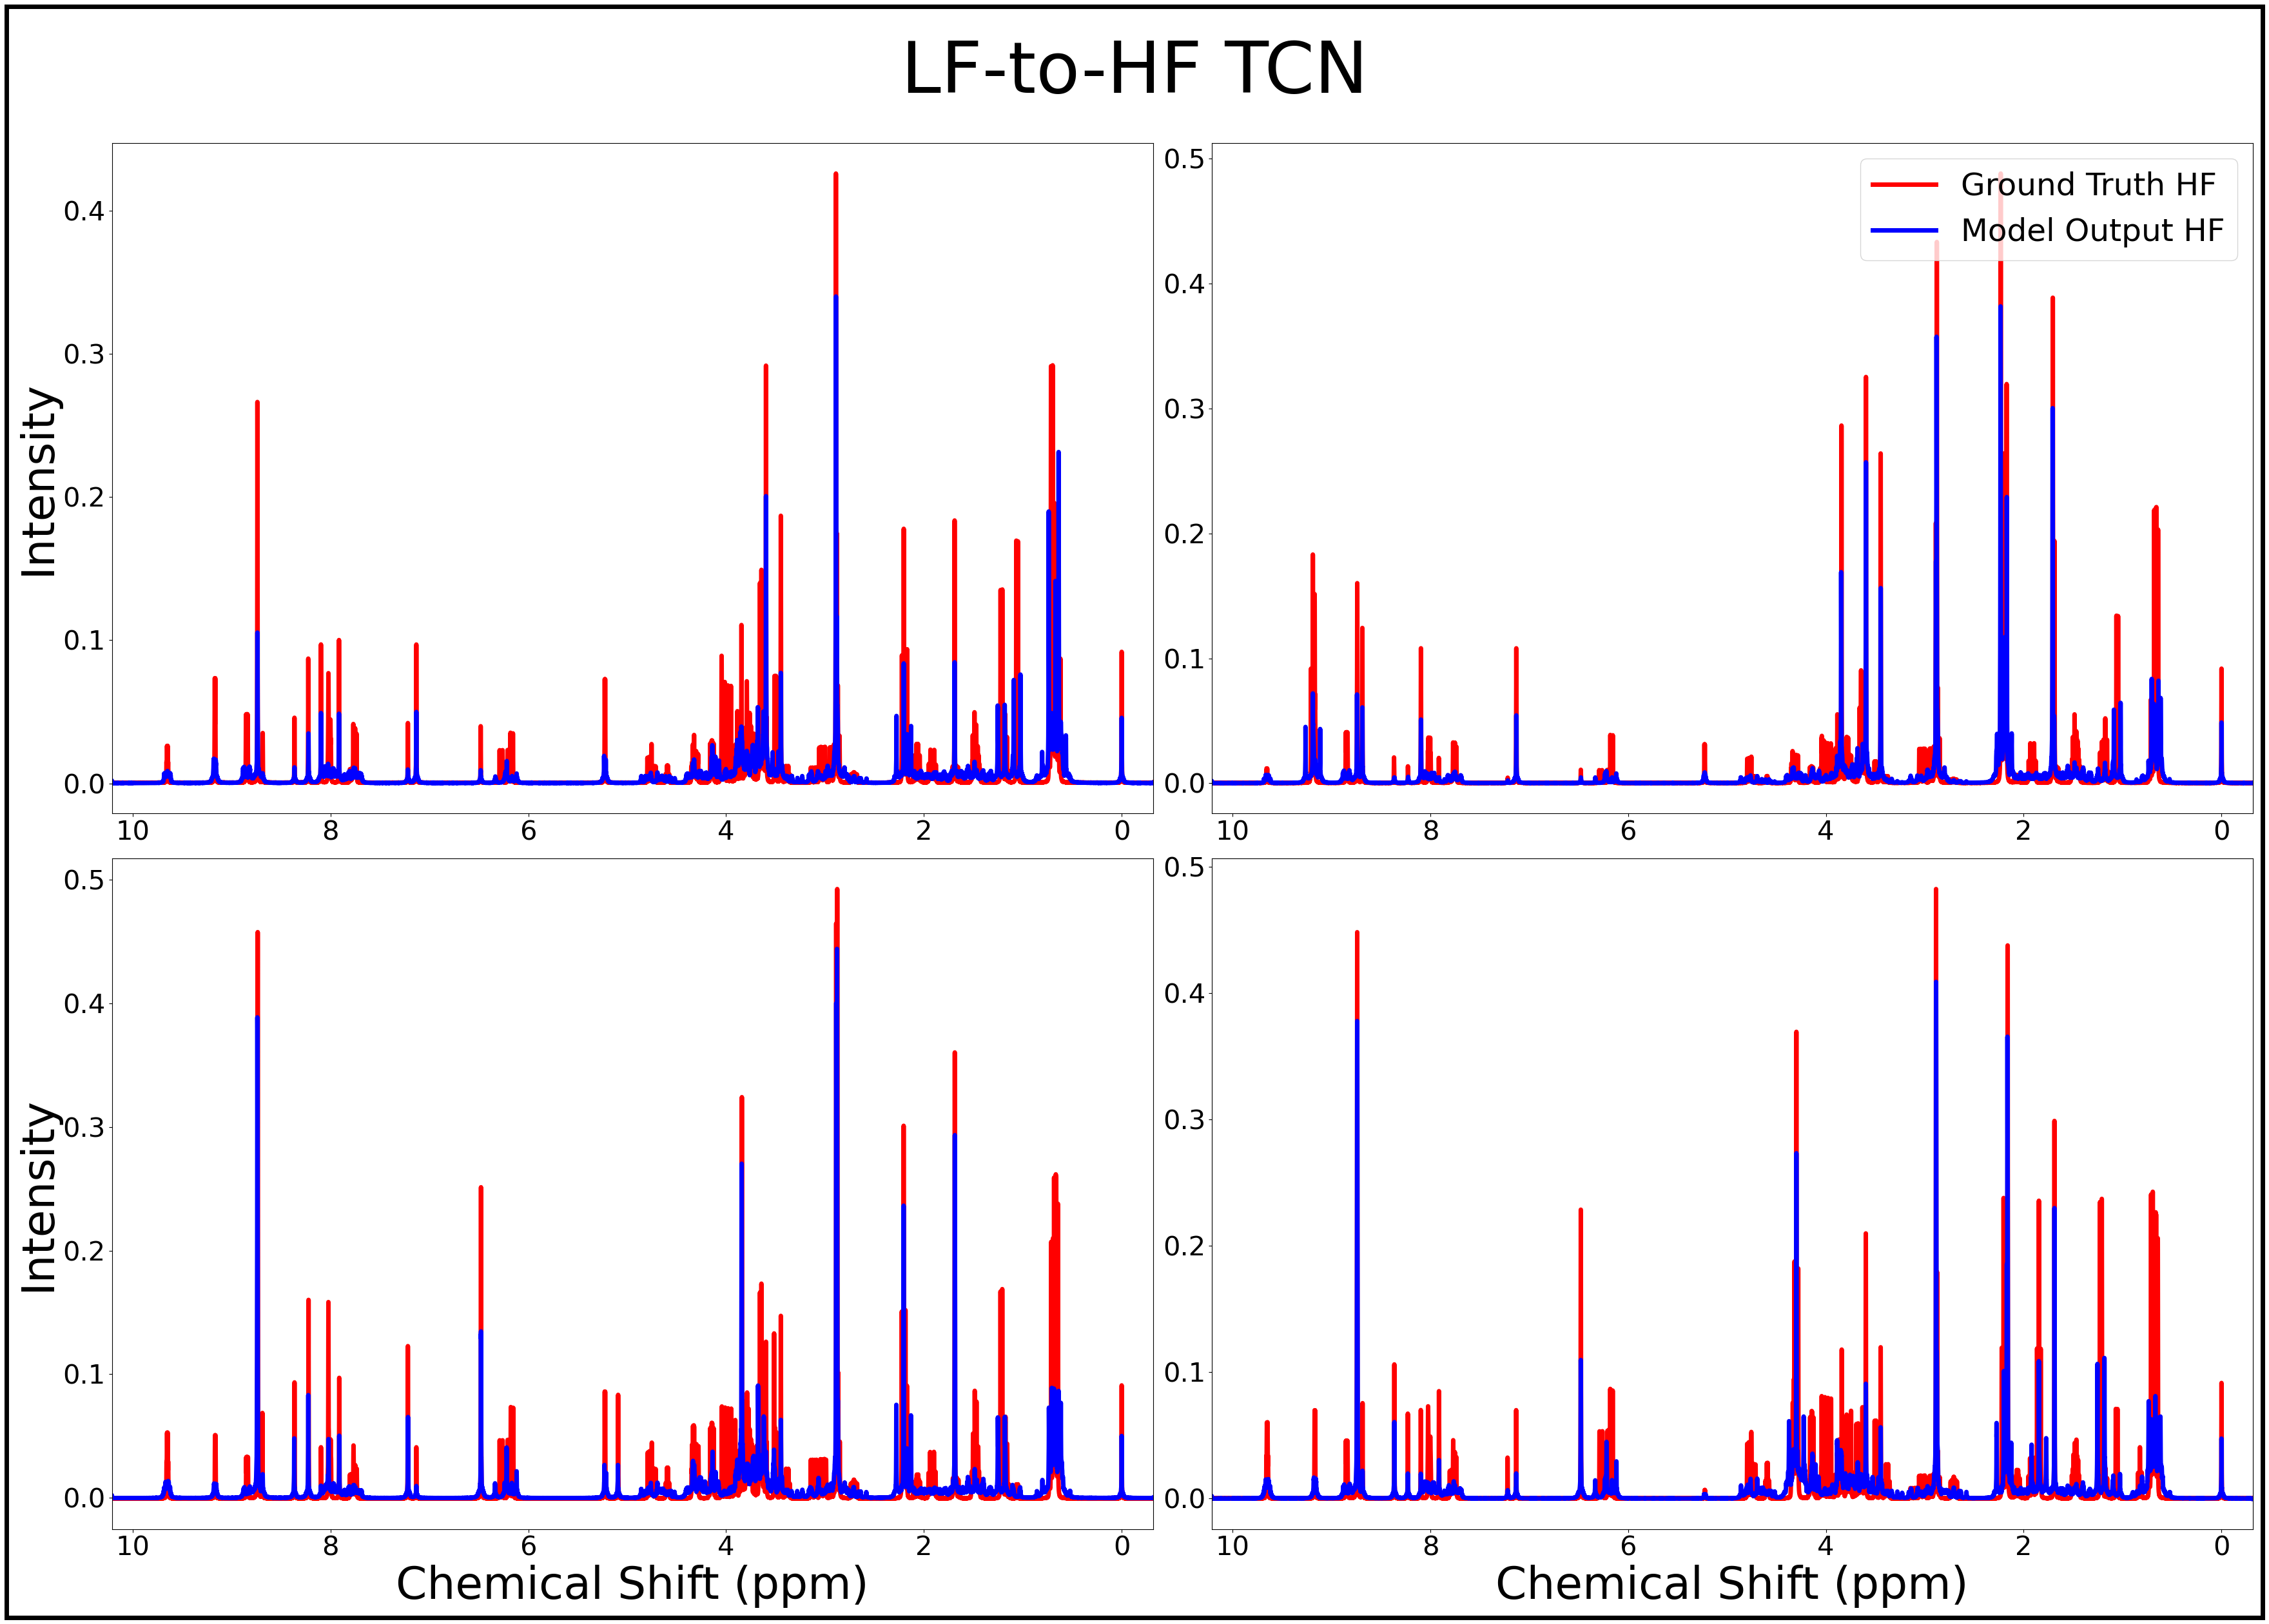

In [12]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')


# Create a figure with 2 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(35, 25))

# Flatten the axes array for easy iteration
axes = axes.flatten()

model.eval()  # Change to evaluation mode (maybe not needed for this model)
outputs = model(LF.unsqueeze(1)).cpu().detach().numpy()

for i in range(4):
    ax = axes[i]
    ax.plot(ppm, GT[i].cpu().detach().numpy(), color='red', linewidth=5, label='Ground Truth HF')
    ax.plot(ppm, outputs[i][0], color='blue', linewidth=5, label='Model Output HF')
    ax.set_xlim(ppm[0], ppm[-1])


    # Add legend to the top-right plot (i == 1)
    if i == 1:
        ax.legend(loc='upper right', fontsize = 35)

    # Set x and y labels for the bottom two plots and left five plots
    if i // 2 == 1:  # Bottom two plots (8, 9)
        ax.set_xlabel('Chemical Shift (ppm)', fontsize=50)
    if i % 2 == 0:  # Left five plots (0, 2, 4, 6, 8)
        ax.set_ylabel('Intensity', fontsize=50)
        
    # Modify the size of the tick marks and numbers
    ax.tick_params(axis='both', which='major', labelsize=30)  # major ticks
    ax.tick_params(axis='both', which='minor', labelsize=30)  # minor ticks

# Add an overall title at the top
fig.suptitle('LF-to-HF TCN', fontsize=80)

# Add a rectangle around the entire figure
rect = plt.Rectangle((0, 0), 1, 1, transform=fig.transFigure, linewidth=5, edgecolor='black', facecolor='none')
fig.patches.append(rect)



plt.tight_layout(rect=[0, 0, 1, 0.97])
# Save the figure as a PNG with high resolution
plt.savefig('LF-to-HF_TCN.png', dpi=600, bbox_inches='tight')

plt.show()

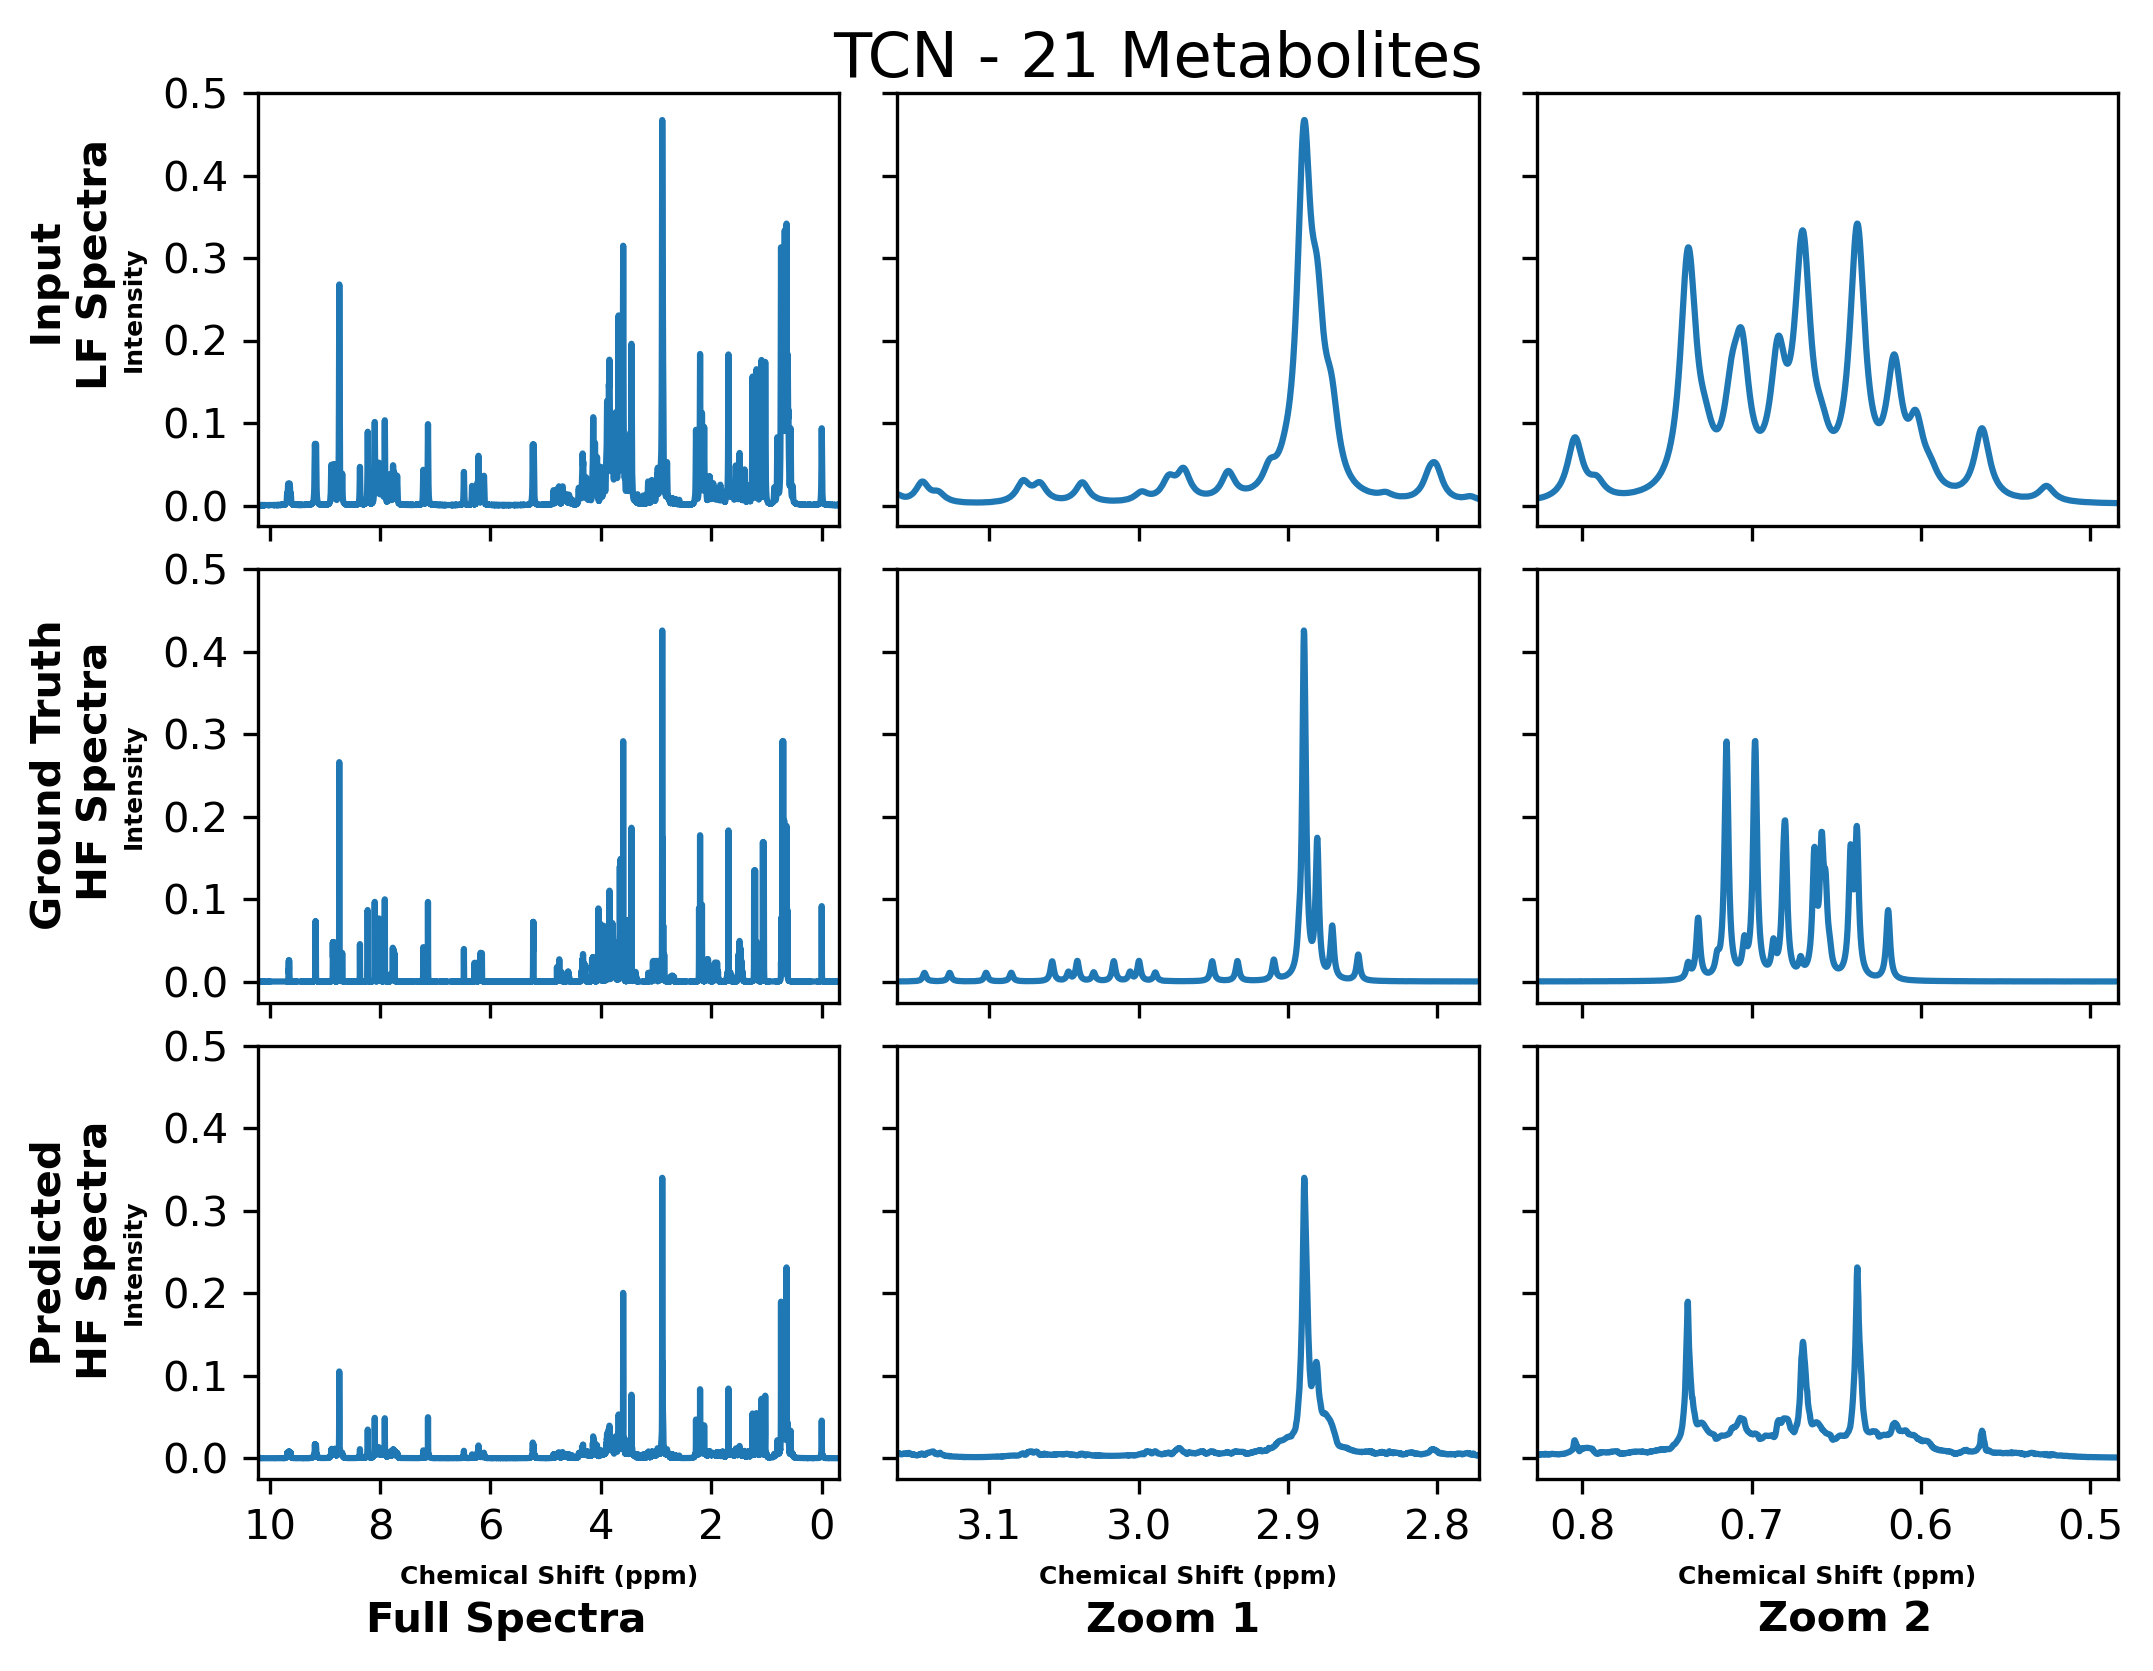

In [14]:
os.chdir('/home/htjhnson/Desktop/LF_to_HF/Figures')

# Get predicted data from the model
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]

# Create figure and subplots with adjusted spacing
fig, axs = plt.subplots(3, 3, figsize=(8, 6), dpi=300)
fig.subplots_adjust(hspace=0.1, wspace=0.1)  # Adjust vertical and horizontal space

# Plotting data for each subplot
axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[0], ppm[-1])
axs[0, 0].set_ylim(-0.025, 0.5)
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800], ppm[32500])
axs[0, 1].set_ylim(-0.025, 0.5)
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000], ppm[42500])
axs[0, 2].set_ylim(-0.025, 0.5)

axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[0], ppm[-1])
axs[1, 0].set_ylim(-0.025, 0.5)
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800], ppm[32500])
axs[1, 1].set_ylim(-0.025, 0.5)
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000], ppm[42500])
axs[1, 2].set_ylim(-0.025, 0.5)

axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[0], ppm[-1])
axs[2, 0].set_ylim(-0.025, 0.5)
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[30800], ppm[32500])
axs[2, 1].set_ylim(-0.025, 0.5)
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41000], ppm[42500])
axs[2, 2].set_ylim(-0.025, 0.5)


# Add main titles inside each subplot
count = -1
plt.rcParams.update({'font.size': 7})
xlabels = ["Chemical Shift (ppm)", "Chemical Shift (ppm)", "Chemical Shift (ppm)"] * 3
ylabels = ["Intensity", "Intensity", "Intensity"] * 3

for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count], fontweight='bold', fontsize=6)
    ax.set_ylabel(ylabels[count], fontweight='bold', fontsize=6)
    
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

    # Add an overall title at the top
fig.suptitle('TCN - 21 Metabolites', fontsize=15, x=0.5, y=0.915)

# Add subtitles as the main titles for each row and column
fig.text(0.03, 0.72, "   Input \nLF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.42, "Ground Truth \n  HF Spectra", rotation='vertical', fontweight='bold', fontsize=10)
fig.text(0.03, 0.17, " Predicted \nHF Spectra", rotation='vertical', fontweight='bold', fontsize=10)

fig.text(0.17, 0.02, "Full Spectra", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.47, 0.02, "Zoom 1", va='bottom', fontweight='bold', fontsize=10)
fig.text(0.75, 0.02, "Zoom 2", va='bottom', fontweight='bold', fontsize=10)

plt.savefig('TCN_Visual.png', dpi=600, bbox_inches='tight')

plt.show()


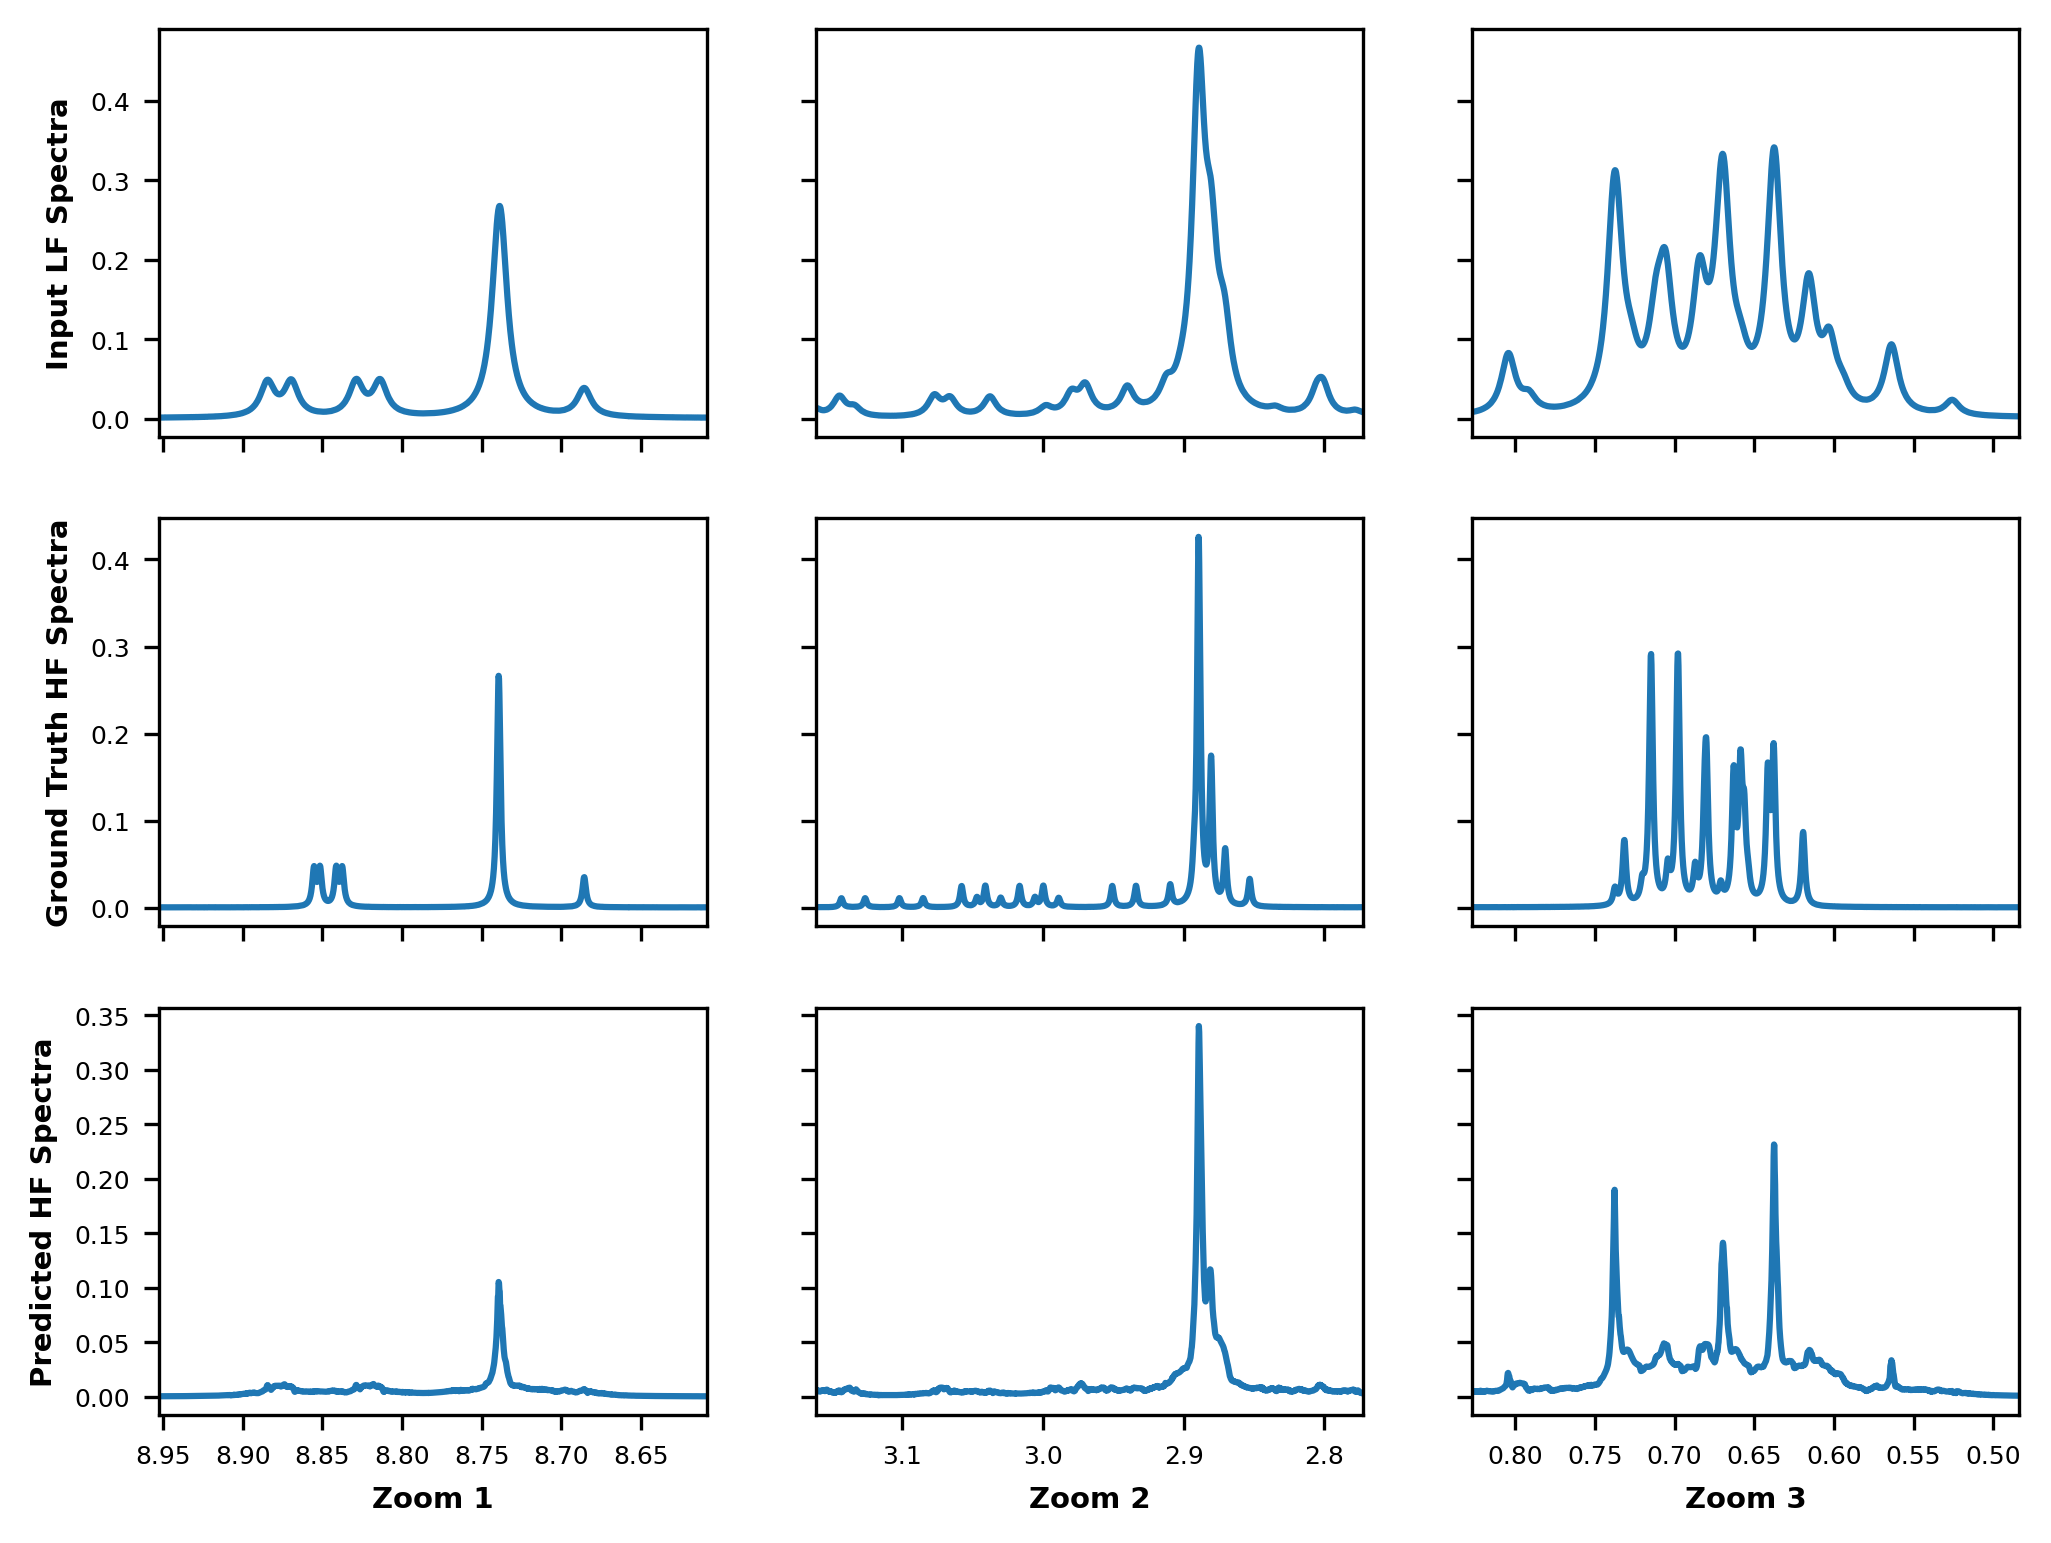

In [14]:
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5500],ppm[7000])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[30800],ppm[32500])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41000],ppm[42500])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5500],ppm[7000])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[30800],ppm[32500])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41000],ppm[42500])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[5500],ppm[7000])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[30800],ppm[32500])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41000],ppm[42500])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')

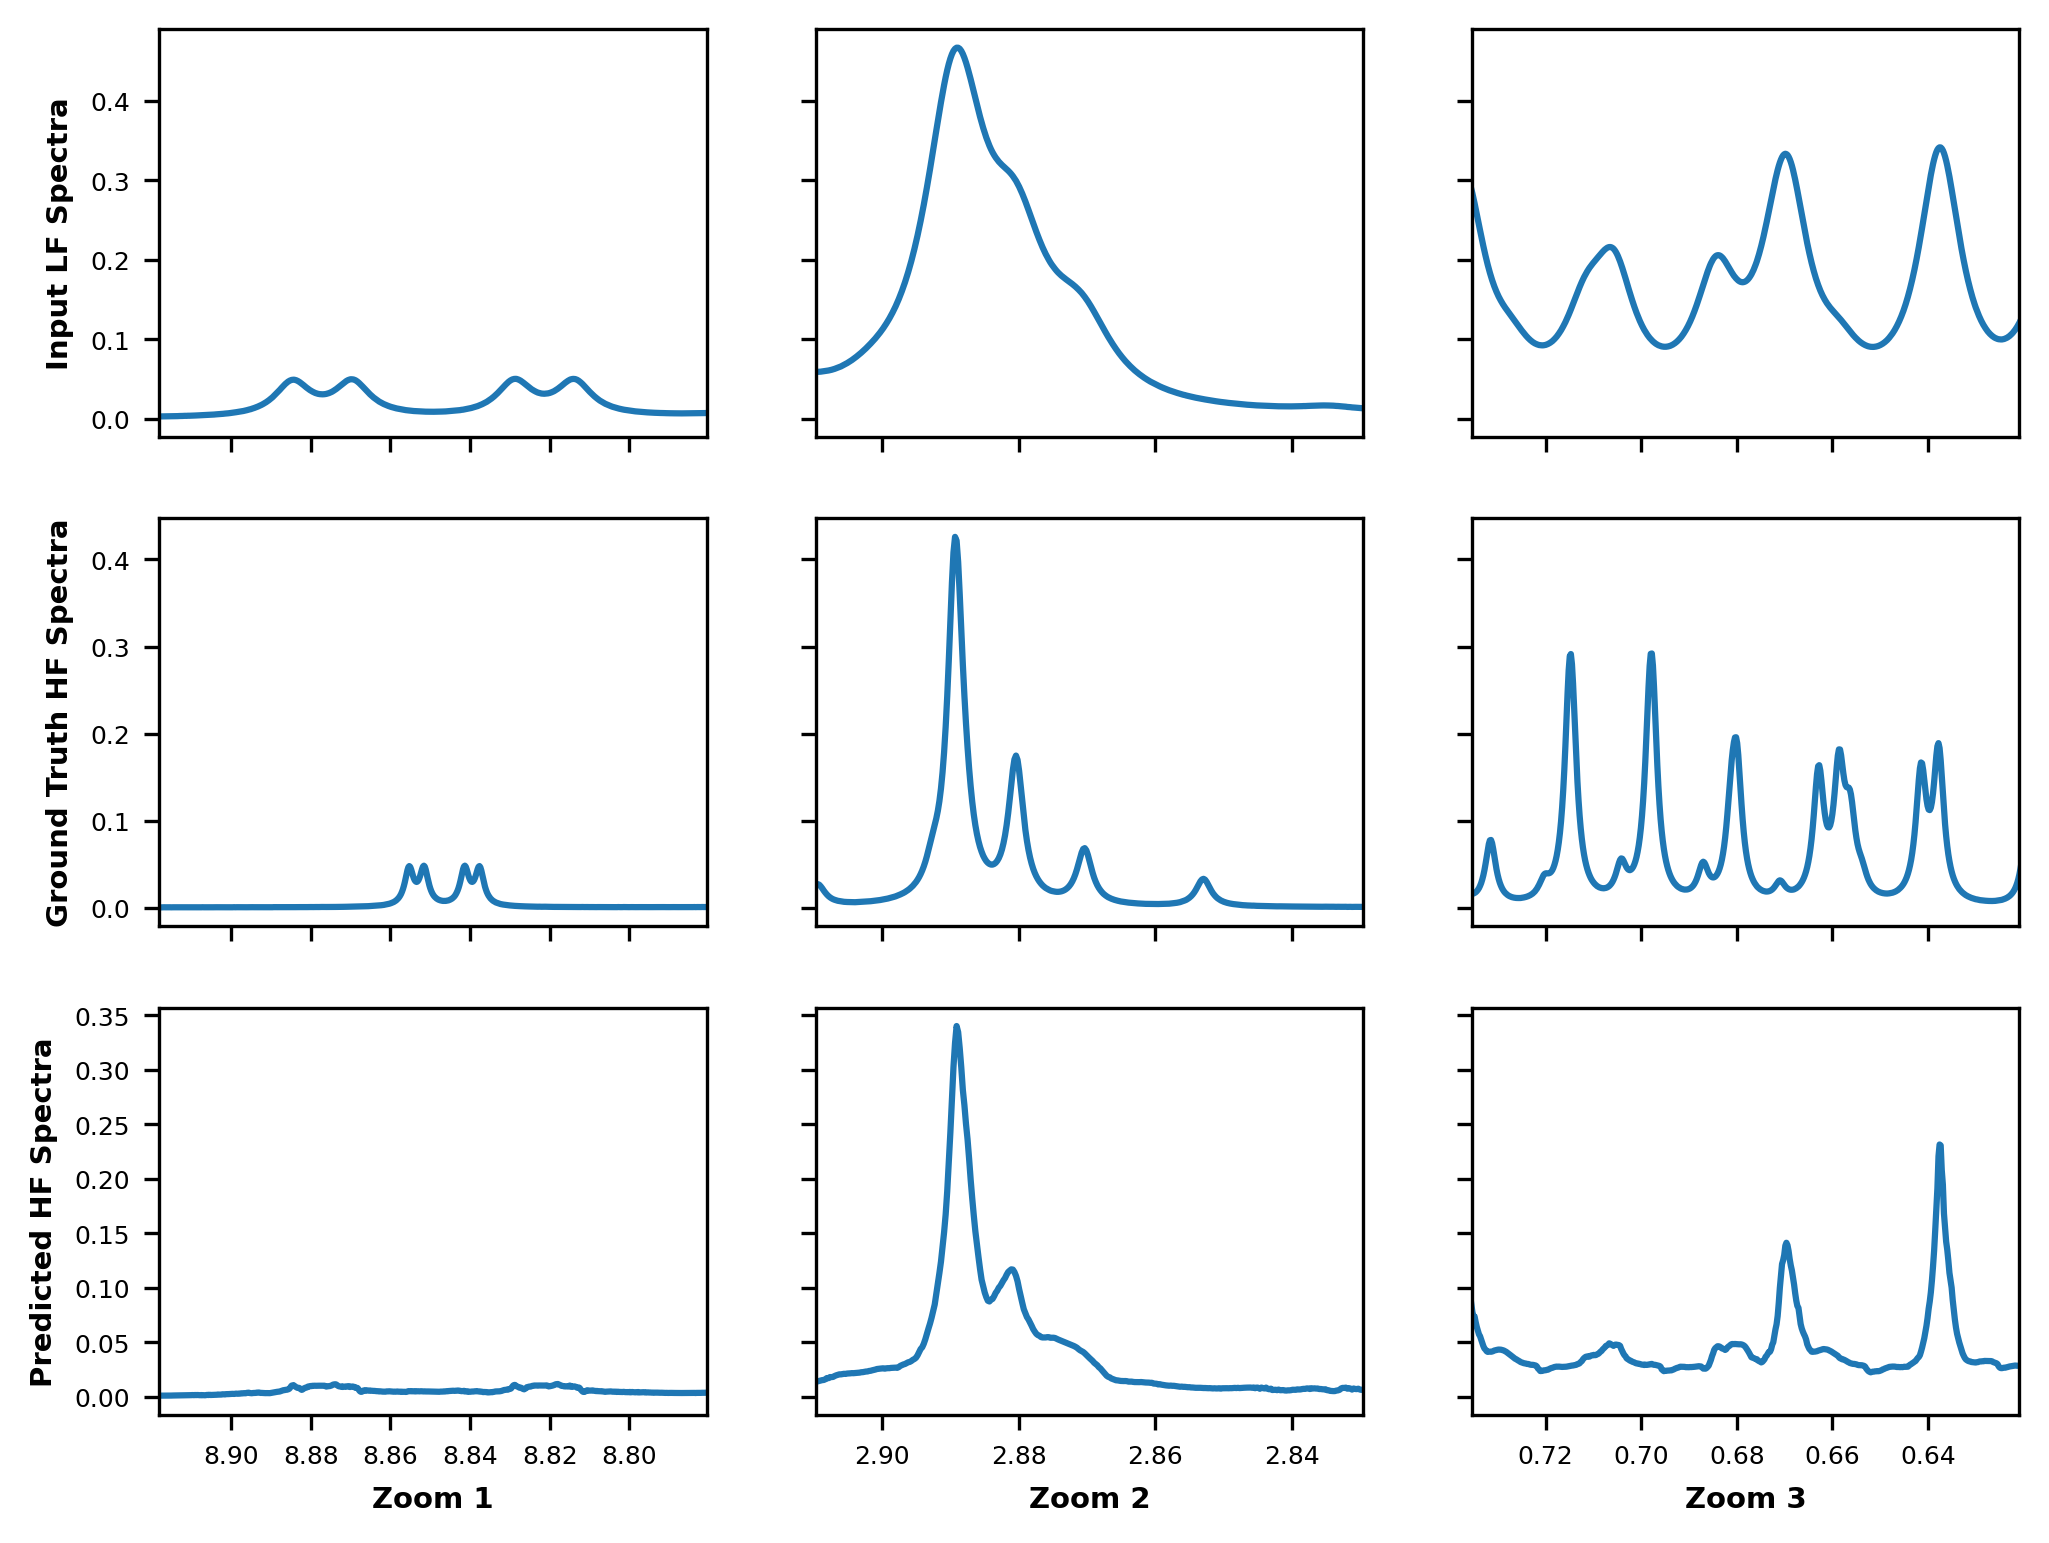

In [15]:
Predicted = model(spectraVal100[0].unsqueeze(0).unsqueeze(0)).cpu().detach().numpy()[0]
#figure(figsize=(8, 6), dpi=300)
fig, axs = plt.subplots(3, 3,figsize=(8,6), dpi=300)

axs[0, 0].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 0].set_xlim(ppm[5650],ppm[6250])
#axs[0, 0].set_ylim([-0.01,0.2])
#axs[0, 0].set_title('Axis [0, 0]')
axs[0, 1].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 1].set_xlim(ppm[31900],ppm[32250])
#axs[0, 1].set_ylim([-0.01,0.2])
#axs[0, 1].set_title('Axis [0, 1]')
axs[0, 2].plot(ppm, spectraVal100[0].cpu().detach().numpy())
axs[0, 2].set_xlim(ppm[41400],ppm[41900])
#axs[0, 2].set_ylim([-0.01,0.2])
#axs[0, 2].set_title('Axis [0, 1]')
axs[1, 0].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 0].set_xlim(ppm[5650],ppm[6250])
#axs[1, 0].set_ylim([-0.01,0.2])
#axs[1, 0].set_title('Axis [1, 0]')
axs[1, 1].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 1].set_xlim(ppm[31900],ppm[32250])
#axs[1, 1].set_ylim([-0.01,0.2])
#axs[1, 1].set_title('Axis [1, 1]')
axs[1, 2].plot(ppm, spectraVal400[0].cpu().detach().numpy())
axs[1, 2].set_xlim(ppm[41400],ppm[41900])
#axs[1, 2].set_ylim([-0.01,0.2])
#axs[1, 2].set_title('Axis [1, 1]')
axs[2, 0].plot(ppm, Predicted[0])
axs[2, 0].set_xlim(ppm[5650],ppm[6250])
#axs[2, 0].set_ylim([-0.01,0.2])
#axs[2, 0].set_title('Axis [1, 0]')
axs[2, 1].plot(ppm, Predicted[0])
axs[2, 1].set_xlim(ppm[31900],ppm[32250])
#axs[2, 1].set_ylim([-0.01,0.2])
#axs[2, 1].set_title('Axis [1, 1]')
axs[2, 2].plot(ppm, Predicted[0])
axs[2, 2].set_xlim(ppm[41400],ppm[41900])
#axs[2, 2].set_ylim([-0.01,0.2])
#axs[2, 2].set_title('Axis [1, 1]')


count = -1
plt.rcParams.update({'font.size': 6})
xlabels = ["Full Spectra","Full Spectra","Full Spectra","Zoom 1","Zoom 1","Zoom 1","Zoom 1","Zoom 2","Zoom 3"]
ylabels = ["Input LF Spectra","Mixture 1","Mixture 1","Ground Truth HF Spectra","Mixture 2","Mixture 2","Predicted HF Spectra","Mixture 2","Mixture 3"]
for ax in axs.flat:
    count += 1
    ax.set_xlabel(xlabels[count],fontweight ='bold',fontsize=7)
    ax.set_ylabel(ylabels[count],fontweight ='bold',fontsize=7)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
    
#plt.savefig('AutoencoderTest1.png')